Processing steps for final calculations after the creation of service areas around Green Quiet Areas (GQA)

#### Step 1 Importing required libraries and load global variables

In [1]:
import geopandas as gpd
import numpy as np
import os
import matplotlib.pyplot as plt
from shapely.geometry import shape, LineString, mapping
from shapely.ops import unary_union, polygonize
import glob
import pandas as pd
import csv
from datetime import datetime


The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
Q:\UserTemp\ubach\AppData\Local\Temp\29\ipykernel_45220\2717615264.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https

In [2]:
# Define engines
engines = {
    'fiona': {'engine': 'fiona'},
    'pyogrio': {'engine': 'pyogrio'},
    'pyogrio+arrow': {'engine': 'pyogrio', 'use_arrow': True}
          
}

In [3]:
def write_log(log_path, log_entry):
    # Check if the file exists to determine if headers need to be written
    file_exists = os.path.isfile(log_path)

    # Open the log file in append mode
    with open(log_path, 'a', newline='') as csvfile:
        log_writer = csv.writer(csvfile)

        # Write the header if the file is new
        if not file_exists:
            log_writer.writerow(["uc_code","uc_name","ctry_code","TotalUCAreaHa",
                                 "UC_UA_AreaHa","UC_UA_Pop","UC_UA_NCM_AreaHa","UC_UA_NCM_Pop",
                                 "Perc_coverage_Area","Perc_coverage_Pop","TotalGreen_urbc_ncm_Ha",
                                 "TotalGreenQuietAreaHa","TotalGQAPop","PercGreenQuietArea",
                                 "PercGreenQuietPop","weighted_median_Ha","TotalGreenAreaHa",
                                 "green_excludedHa"])

        # Write the log entry
        log_writer.writerow(log_entry)

def create_log_entry(val1, val2, val3, val4, val5, val6, val7, val8, val9, val10, val11, val12, val13, val14, val15, val16, val17, val18):
    return [val1, val2, val3, val4, val5, val6, val7, val8, val9, val10, val11, val12, val13, val14, val15, val16, val17, val18]


In [4]:
# Path to data folders
indata_f = r'P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas'
step2_f = os.path.join(indata_f, 'OutputData', 'SA')
outdata_f = r'P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas\OutputData'
ua_data_f = r'A:\Copernicus\UrbanAtlas\UrbanAtlas\UA2018'
# Load urban center delineation
path = os.path.join(indata_f, 'UrbanCentres', 'HDC2021_RG_InputUpdateB2B3.shp') 
urban_centers = gpd.read_file(path)

# NOISE DATA
# Load agglomerations delineations
agls_file_path = os.path.join(indata_f, 'NoiseData', 'DF1_5_Agglomerations_20240429.gpkg')
# Read the GeoPackage file
agls = gpd.read_file(agls_file_path, layer = 'dbo.DF15_AgglomerationSource_Valid_LatestDelivery', 
                     **engines['pyogrio+arrow'],columns=['agglomerationId_identifier', 'agglomerationName_nameEng', 'geometry'])

ncm_file_path = os.path.join(indata_f, 'NoiseData', f'Noise_20202025_export.gpkg')

# TRANSLATOR TABLE
# Crosswalk table containing the different codes from input sources
codes_path = r'P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas\Processing\Codes.csv'
codes = pd.read_csv(codes_path)

# GQA
path2FinalGQA = r'P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas\OutputData\GQA'

# FINAL OUTPUT TABLE
csv_name = 'GQATotals_v2024_1309.csv'
csv_path = os.path.join(outdata_f, csv_name)

In [5]:
tbl = pd.read_csv(csv_path)

In [6]:
tbl

,uc_code,uc_name,ctry_code,TotalUCAreaHa,UC_UA_AreaHa,UC_UA_Pop,UC_UA_NCM_AreaHa,UC_UA_NCM_Pop,Perc_coverage_Area,Perc_coverage_Pop,TotalGreen_urbc_ncm_Ha,TotalGreenQuietAreaHa,TotalGQAPop,PercGreenQuietArea,PercGreenQuietPop,weighted_median_Ha,TotalGreenAreaHa,green_excludedHa
0,GEOSTAT21_022,Örebro,SE,2700.0,2700.00,96771,2700.00,96771,100.00,100.00,569.89,139.15,22015,24.416993,22.749584,88.22,569.89,0.00
1,GEOSTAT21_914,Jönköping / Huskvarna,SE,2400.0,2400.00,70478,2400.00,70478,100.00,100.00,528.42,354.01,33655,66.994058,47.752490,98.69,528.42,0.00
2,GEOSTAT21_026,Borås,SE,2400.0,2400.00,67212,2400.00,67212,100.00,100.00,563.43,315.34,26132,55.967911,38.879962,65.28,563.43,0.00
3,GEOSTAT21_070,Elbląg,PL,1600.0,1600.00,113020,1586.44,113002,99.15,99.98,143.86,70.60,19422,49.075490,17.187306,29.00,144.42,0.56
4,GEOSTAT21_086,Kiel,DE,6400.0,6179.77,223906,5121.94,205100,80.03,91.60,648.64,261.42,74141,40.302787,36.148708,65.10,814.23,165.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,GEOSTAT21_901,Helsinki,FI,33300.0,31666.74,995310,31660.37,1015350,95.08,102.01,8727.79,150.00,9771,1.718648,0.962328,88.85,8728.36,0.57
264,GEOSTAT21_903,København,DK,29900.0,29526.94,985906,26670.16,932438,89.20,94.58,3037.25,1620.82,294470,53.364721,31.580652,98.44,3344.86,307.61
265,GEOSTAT21_904,Dublin,IE,32700.0,32022.31,1136468,31178.32,1136138,95.35,99.97,3583.76,1829.20,485270,51.041364,42.712241,91.57,3593.16,9.40
266,GEOSTAT21_905,Utrecht,NL,5800.0,5800.00,341648,5768.14,341638,99.45,100.00,557.20,240.73,151051,43.203518,44.213758,90.11,566.74,9.54


In [7]:
tbl.query('uc_name=="Bilbao"')

,uc_code,uc_name,ctry_code,TotalUCAreaHa,UC_UA_AreaHa,UC_UA_Pop,UC_UA_NCM_AreaHa,UC_UA_NCM_Pop,Perc_coverage_Area,Perc_coverage_Pop,TotalGreen_urbc_ncm_Ha,TotalGreenQuietAreaHa,TotalGQAPop,PercGreenQuietArea,PercGreenQuietPop,weighted_median_Ha,TotalGreenAreaHa,green_excludedHa
76,GEOSTAT21_650,Bilbao,ES,7700.0,7495.99,767507,2236.01,442007,29.04,57.59,222.84,44.71,160402,20.063723,36.289471,89.44,690.88,468.04
145,GEOSTAT21_650,Bilbao,ES,7700.0,7495.99,767507,2236.01,442007,29.04,57.59,222.84,44.71,160402,20.063723,36.289471,89.44,690.88,468.04
255,GEOSTAT21_650,Bilbao,ES,7700.0,7495.99,767507,2236.01,442007,29.04,57.59,222.84,44.71,160402,20.063723,36.289471,89.44,690.88,468.04


In [8]:
tbl_no_duplicates = tbl.drop_duplicates()
tbl_no_duplicates.query('uc_name=="Bilbao"')

,uc_code,uc_name,ctry_code,TotalUCAreaHa,UC_UA_AreaHa,UC_UA_Pop,UC_UA_NCM_AreaHa,UC_UA_NCM_Pop,Perc_coverage_Area,Perc_coverage_Pop,TotalGreen_urbc_ncm_Ha,TotalGreenQuietAreaHa,TotalGQAPop,PercGreenQuietArea,PercGreenQuietPop,weighted_median_Ha,TotalGreenAreaHa,green_excludedHa
76,GEOSTAT21_650,Bilbao,ES,7700.0,7495.99,767507,2236.01,442007,29.04,57.59,222.84,44.71,160402,20.063723,36.289471,89.44,690.88,468.04


In [9]:
tbl_no_duplicates

,uc_code,uc_name,ctry_code,TotalUCAreaHa,UC_UA_AreaHa,UC_UA_Pop,UC_UA_NCM_AreaHa,UC_UA_NCM_Pop,Perc_coverage_Area,Perc_coverage_Pop,TotalGreen_urbc_ncm_Ha,TotalGreenQuietAreaHa,TotalGQAPop,PercGreenQuietArea,PercGreenQuietPop,weighted_median_Ha,TotalGreenAreaHa,green_excludedHa
0,GEOSTAT21_022,Örebro,SE,2700.0,2700.00,96771,2700.00,96771,100.00,100.00,569.89,139.15,22015,24.416993,22.749584,88.22,569.89,0.00
1,GEOSTAT21_914,Jönköping / Huskvarna,SE,2400.0,2400.00,70478,2400.00,70478,100.00,100.00,528.42,354.01,33655,66.994058,47.752490,98.69,528.42,0.00
2,GEOSTAT21_026,Borås,SE,2400.0,2400.00,67212,2400.00,67212,100.00,100.00,563.43,315.34,26132,55.967911,38.879962,65.28,563.43,0.00
3,GEOSTAT21_070,Elbląg,PL,1600.0,1600.00,113020,1586.44,113002,99.15,99.98,143.86,70.60,19422,49.075490,17.187306,29.00,144.42,0.56
4,GEOSTAT21_086,Kiel,DE,6400.0,6179.77,223906,5121.94,205100,80.03,91.60,648.64,261.42,74141,40.302787,36.148708,65.10,814.23,165.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,GEOSTAT21_665,León,ES,2500.0,2500.00,160259,1775.20,126078,71.01,78.67,103.23,37.65,89258,36.471956,70.795857,205.05,114.72,11.49
147,GEOSTAT21_025,Linköping,SE,3000.0,3000.00,97946,3000.00,97946,100.00,100.00,675.85,547.43,78045,80.998742,79.681661,155.95,675.85,0.00
148,GEOSTAT21_024,Norrköping,SE,2500.0,2500.00,92614,2500.00,92614,100.00,100.00,464.60,266.38,58122,57.335342,62.757251,138.80,464.60,0.00
149,GEOSTAT21_021,Tartu,EE,2400.0,2400.00,84562,2321.68,84316,96.74,99.71,192.00,136.55,52424,71.119792,62.175625,95.98,193.55,1.55


In [10]:
tbl_no_duplicates.to_csv(csv_path)

In [ ]:
tbl_no_duplicates

In [5]:
codes.head()

,FREQUENCY,HDENS_CLST,HDENS_NAME,HDENS_2011,agglomerationId_identifier,agglomerationName_nameEng,UA2018
0,1,GEOSTAT21_002,Oulu / Uleåborg,GEOSTAT11_002,AG_FI_00_6,Oulu,FI004L4_OULU_UA2018_v013
1,1,GEOSTAT21_003,Umeå,GEOSTAT11_003,SE_a_ag2480,Umea,SE005L1_UMEA_UA2018_v013
2,1,GEOSTAT21_004,Trondheim,GEOSTAT11_004,AG_NO_00_3,Trondheim,NO003L1_TRONDHEIM_UA2018_v013
3,1,GEOSTAT21_005,Jyväskylä,GEOSTAT11_005,AG_FI_00_9,Jyvaskyla,FI009L2_JYVASKYLA_UA2018_v013
4,1,GEOSTAT21_006,Tampere / Tammerfors,GEOSTAT11_006,AG_FI_00_3,Tampere,FI002L3_TAMPERE_UA2018_v013


In [6]:
if os.path.exists(csv_path): 
    outtbl = pd.read_csv(csv_path)
    cities_ls = outtbl.uc_code.to_list()
else:
    cities_ls = []

SA_ls = glob.glob(os.path.join(step2_f, '*.shp'))

In [8]:
len(SA_ls)

133

In [9]:
for sa_name in SA_ls[90:110]:
    print(os.path.basename(sa_name)[:-7])

GEOSTAT21_904
GEOSTAT21_903
GEOSTAT21_901
GEOSTAT21_856
GEOSTAT21_843
GEOSTAT21_706
GEOSTAT21_689
GEOSTAT21_669
GEOSTAT21_665


In [13]:
(68/16)*4*3

51.0

# All together

In [15]:
if os.path.exists(csv_path): 
    outtbl = pd.read_csv(csv_path)
    cities_ls = outtbl.uc_code.to_list()
else:
    cities_ls = []

SA_ls = glob.glob(os.path.join(step2_f, '*.shp'))


# Print the list of shapefiles
for sa_name in SA_ls[40:66]:
    uc_code = os.path.basename(sa_name)[:-7]
    uc_name = codes.query(f'HDENS_CLST=="{uc_code}"').HDENS_NAME.values[0]
    print(f'{uc_name} {uc_code}')
    
    if uc_code not in cities_ls:

        # Load urban center
        urban_center = urban_centers.query(f'HDENS_CLST=="{uc_code}"')
        ctry_code = urban_centers.query(f'HDENS_CLST=="{uc_code}"').CNTR_CODE.values[0]
        TotalUCArea = urban_center.geometry.area.sum()
        TotalUCAreaHa = round(TotalUCArea/10000,2)  

        # Erase those areas of SA overlapping the GUAs
        # Load QGA
        path = os.path.join(path2FinalGQA, f'{uc_code}_finalGQA.shp')
        GQA = gpd.read_file(path)

        # Remove the outer areas from urban centers      
        file_path = os.path.join(outdata_f, f'{uc_code}_SA_GQA_urbc.shp')
        if not os.path.exists(file_path):
            # Remove GQA delineation from the SA
            SA_GQA_urbc = gpd.overlay(SA_GQA_total, urban_center, how='intersection')
            SA_GQA_urbc.to_file(file_path, driver='ESRI Shapefile')     
        else:
            SA_GQA_urbc = gpd.read_file(file_path)

        #### Final computations including population
        ## Compute Total Green Areas
        # Read Urban Atlas data
        ua_path = codes.query(f'HDENS_CLST=="{uc_code}"').UA2018.values[0].strip()
        file_path = os.path.join(ua_data_f, f'{ua_path}\Data\{ua_path}.gpkg')
        # Read the GeoPackage file
        ua = gpd.read_file(file_path, layer= ua_path[:-5], 
                    columns= ['code_2018','Pop2018','geometry'], engine='pyogrio', 
                    use_arrow=True, bbox= tuple(urban_center.total_bounds))
        
        ua_urbc = gpd.overlay(ua, urban_center, how='intersection')
        UC_UA_Area = ua_urbc.geometry.area.sum()
        UC_UA_AreaHa = round(UC_UA_Area/10000,2)
        UC_UA_Pop = int(ua_urbc.Pop2018.sum())
        
        # area of analysis
        ua_urbc_agl = gpd.overlay(ua_urbc, agls, how='intersection')
        UC_UA_NCM_AreaHa = round(ua_urbc_agl.geometry.area.sum()/10000,2)
        UC_UA_NCM_Pop = int(ua_urbc_agl.Pop2018.sum())

        # Perc coverage area
        # UC_NCM_UA_Area/Ref Area*100
        Perc_coverage_Area = round((UC_UA_NCM_AreaHa/TotalUCAreaHa)*100,2)
        
        # Perc coverage popultation
        # UC_NCM_UA_Pop/UC_UA_Pop*100
        Perc_coverage_Pop = round((UC_UA_NCM_Pop/UC_UA_Pop)*100,2)
  
        # All green areas (GUAs and forests) in the urban center (including data outside the ncm)
        TotalGreenArea = ua_urbc.query('code_2018 == "14100" or code_2018 == "31000"').geometry.area.sum()
        TotalGreenAreaHa = round(TotalGreenArea/10000,2)

        # green in the study area
        ua_urbc_agl_green = ua_urbc_agl.query('code_2018 == "14100" or code_2018 == "31000"')
        TotalGreen_urbc_ncm_Ha = round(ua_urbc_agl_green.geometry.area.sum()/10000,2)
        # save to file
        file_path = os.path.join(outdata_f, 'Green_inUCUA_Aglos', f'{uc_code}_greenUCUANCM.shp')
        if not os.path.exists(file_path):
            ua_urbc_agl_green.to_file(file_path, driver='ESRI Shapefile')

        # Excluded areas = TotalGreen in the urban center - TotalGreen in the uc & ncm 
        green_excludedHa = TotalGreenAreaHa - TotalGreen_urbc_ncm_Ha
        
        # Total Green Quiet Areas
        TotalGreenQuietAreaHa = round(GQA.area.sum()/10000,2)

        # Percentage of Green Quiet Areas
        ## Computed as:
        ## % of green quiet areas =  TotalGQA/(TotalGreenAreas-Green excluded) * 100
        ### Quiet_Area/UC_NCM_UA_Green_Area*100
        PercGreenQuietArea = TotalGreenQuietAreaHa/(TotalGreen_urbc_ncm_Ha)*100

        # Computing Population
        ua['original_area_m2'] = round(ua.geometry.area,2)
        SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua,how='intersection')  
        if not SA_GQA_ua.empty:  
            if 'total_area_m2' not in SA_GQA_ua.columns:
                SA_GQA_ua['total_area_m2'] = SA_GQA_ua['total_area']
            SA_GQA_ua = SA_GQA_ua[['unique_id', 'total_area_m2','code_2018', 'Pop2018','original_area_m2', 'geometry']]
            SA_GQA_ua['final_area_m2'] = round(SA_GQA_ua.geometry.area,2)
            SA_GQA_ua['area_prop'] = SA_GQA_ua['final_area_m2']/SA_GQA_ua['original_area_m2'] # capture proportion from original geometry
            SA_GQA_ua['Pop2018_poly'] = SA_GQA_ua['Pop2018']*SA_GQA_ua['area_prop']
            SA_GQA_ua['Pop2018_final'] = round(SA_GQA_ua.Pop2018_poly,0)
            TotalGQAPop = int(SA_GQA_ua.Pop2018_final.sum())

            # Perc Population
            # TotalGQAPop/UC_NCM_UA_Pop*100
            PercGreenQuietPop = TotalGQAPop/UC_UA_NCM_Pop*100

            # compute the weighted median for the area
            column_to_compute_median = 'total_area_m2'
            weighted_median_m2 = np.average(SA_GQA_ua[column_to_compute_median], weights=SA_GQA_ua['Pop2018_poly'])
            weighted_median_Ha = round(weighted_median_m2/10000,2)

            # Write values to output table
            log_entry = create_log_entry(uc_code , uc_name , ctry_code , TotalUCAreaHa ,
                                  UC_UA_AreaHa , UC_UA_Pop , UC_UA_NCM_AreaHa , UC_UA_NCM_Pop ,
                                  Perc_coverage_Area , Perc_coverage_Pop , TotalGreen_urbc_ncm_Ha ,
                                  TotalGreenQuietAreaHa , TotalGQAPop , PercGreenQuietArea ,
                                  PercGreenQuietPop , weighted_median_Ha , TotalGreenAreaHa ,
                                  green_excludedHa)
            write_log(csv_path, log_entry)

    


Gent GEOSTAT21_332
Wrocław GEOSTAT21_318
Antwerpen GEOSTAT21_317
Eindhoven GEOSTAT21_292
Rotterdam GEOSTAT21_240
Zielona Góra GEOSTAT21_233
Zwolle GEOSTAT21_177
Warszawa GEOSTAT21_171
Włocławek GEOSTAT21_150
Bremen GEOSTAT21_145
Groningen GEOSTAT21_137
Cork GEOSTAT21_132
Limerick GEOSTAT21_095
Gdańsk GEOSTAT21_068
Odense GEOSTAT21_060
Malmö GEOSTAT21_054
Kaunas GEOSTAT21_051
Lund GEOSTAT21_049
Helsingborg GEOSTAT21_048
Århus GEOSTAT21_047
Aalborg GEOSTAT21_031


Q:\UserTemp\ubach\AppData\Local\Temp\3\ipykernel_19400\3531030639.py:76: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ua_urbc_agl_green.to_file(file_path, driver='ESRI Shapefile')
Q:\UserTemp\ubach\AppData\Local\Temp\3\ipykernel_19400\3531030639.py:92: UserWarning: `keep_geom_type=True` in overlay resulted in 870 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua,how='intersection')


Rīga GEOSTAT21_028


Q:\UserTemp\ubach\AppData\Local\Temp\3\ipykernel_19400\3531030639.py:76: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ua_urbc_agl_green.to_file(file_path, driver='ESRI Shapefile')
Q:\UserTemp\ubach\AppData\Local\Temp\3\ipykernel_19400\3531030639.py:92: UserWarning: `keep_geom_type=True` in overlay resulted in 913 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua,how='intersection')


Linköping GEOSTAT21_025


Q:\UserTemp\ubach\AppData\Local\Temp\3\ipykernel_19400\3531030639.py:48: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\3\ipykernel_19400\3531030639.py:76: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ua_urbc_agl_green.to_file(file_path, driver='ESRI Shapefile')
c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\pygeos\set_operations.py:129: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
Q:\UserTemp\ubach\AppData\Local\Temp\3\ipykernel_19400\3531030639.py:92: UserWarning: `keep_geom_type=True` in overlay resulted in 1080 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_GQA_u

Norrköping GEOSTAT21_024


Q:\UserTemp\ubach\AppData\Local\Temp\3\ipykernel_19400\3531030639.py:76: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ua_urbc_agl_green.to_file(file_path, driver='ESRI Shapefile')
Q:\UserTemp\ubach\AppData\Local\Temp\3\ipykernel_19400\3531030639.py:92: UserWarning: `keep_geom_type=True` in overlay resulted in 694 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua,how='intersection')


Tartu GEOSTAT21_021


Q:\UserTemp\ubach\AppData\Local\Temp\3\ipykernel_19400\3531030639.py:76: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ua_urbc_agl_green.to_file(file_path, driver='ESRI Shapefile')
Q:\UserTemp\ubach\AppData\Local\Temp\3\ipykernel_19400\3531030639.py:92: UserWarning: `keep_geom_type=True` in overlay resulted in 619 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua,how='intersection')


Stockholm GEOSTAT21_018


Q:\UserTemp\ubach\AppData\Local\Temp\3\ipykernel_19400\3531030639.py:48: UserWarning: `keep_geom_type=True` in overlay resulted in 93 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\3\ipykernel_19400\3531030639.py:92: UserWarning: `keep_geom_type=True` in overlay resulted in 6172 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua,how='intersection')


In [ ]:
["uc_code","uc_name","ctry_code","TotalUCAreaHa",
                        "UC_UA_AreaHa","UC_UA_Pop","UC_UA_NCM_AreaHa","UC_UA_NCM_Pop",
                        "Perc_coverage_Area","Perc_coverage_Pop","TotalGreen_urbc_ncm_Ha",
                        "TotalGreenQuietAreaHa","TotalGQAPop","PercGreenQuietArea",
                        "PercGreenQuietPop","weighted_median_Ha","TotalGreenAreaHa",
                        "green_excludedHa"])


In [ ]:
log_entry = create_log_entry(uc_code, uc_name, ctry_code, TotalUCAreaHa, TotalGreenAreaHa,
                            green_excludedHa, TotalGreenQuietAreaHa, PercGreenQuietArea,
                            weighted_median_Ha, TotalGQAPop, TotalPop)
write_log(csv_path, log_entry)

In [16]:
uc_code

'GEOSTAT21_022'

In [18]:
log_entry=create_log_entry(uc_code,uc_name,ctry_code,TotalUCAreaHa,
    UC_UA_AreaHa,UC_UA_Pop,UC_UA_NCM_AreaHa,UC_UA_NCM_Pop,
    Perc_coverage_Area,Perc_coverage_Pop,TotalGreen_urbc_ncm_Ha,
    TotalGreenQuietAreaHa,TotalGQAPop,PercGreenQuietArea,
    PercGreenQuietPop,weighted_median_Ha,TotalGreenAreaHa,
    green_excludedHa)
write_log(csv_path,log_entry)

# Test Stockholm, Porto, and Boras

In [5]:
cities_ls2 = ['GEOSTAT21_843','GEOSTAT21_706', 'GEOSTAT21_022', 'GEOSTAT21_018']
cities_ls2

['GEOSTAT21_843', 'GEOSTAT21_706', 'GEOSTAT21_022', 'GEOSTAT21_018']

In [6]:
SA_ls2 = [ 'P:\\Environment and Health\\Noise\\ServiceContract\\2024_ServiceContract\\QuietAreas\\OutputData\\SA\\GEOSTAT21_843_SA.shp',
          'P:\\Environment and Health\\Noise\\ServiceContract\\2024_ServiceContract\\QuietAreas\\OutputData\\SA\\GEOSTAT21_706_SA.shp',
          'P:\\Environment and Health\\Noise\\ServiceContract\\2024_ServiceContract\\QuietAreas\\OutputData\\SA\\GEOSTAT21_022_SA.shp',
          'P:\\Environment and Health\\Noise\\ServiceContract\\2024_ServiceContract\\QuietAreas\\OutputData\\SA\\GEOSTAT21_018_SA.shp'
          ]

In [7]:
testdata_f = r'P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas\OutputData\tests\GreenUC'
# FINAL OUTPUT TABLE
csv_name = 'GQA_v2024_1209_GreenPerc.csv'
csv_path = os.path.join(outdata_f, csv_name)

cities_ls3=[]
# Print the list of shapefiles
for sa_name in SA_ls2:
    uc_code = os.path.basename(sa_name)[:-7]
    if uc_code not in cities_ls3:
        SA = gpd.read_file(sa_name)
        SA.loc[:, 'FID_GQA'] = SA['Name'].str.split(":").str[0]
        uc_name = codes.query(f'HDENS_CLST=="{uc_code}"').HDENS_NAME.values[0]
        print(f'{uc_name} {uc_code}')
        print(str(datetime.now()))
        
        # Dissolve by GQA identifier 
        file_path = os.path.join(outdata_f, f'{uc_code}_SA_FID_dis.shp')
        if not os.path.exists(file_path):
            SA_FID_dis = SA.dissolve('FID_GQA')
            SA_FID_dis.reset_index(inplace=True)
            SA_FID_dis.to_file(file_path, driver='ESRI Shapefile')

        # Erase those areas of SA overlapping the GUAs
        # Load QGA
        path = os.path.join(path2FinalGQA, f'{uc_code}_finalGQA.shp')
        GQA = gpd.read_file(path)

        # Remove QGA delineation from the SA
        file_path = os.path.join(outdata_f, f'{uc_code}_SA_final.shp')
        if not os.path.exists(file_path):
            SA_final = gpd.overlay(SA_FID_dis, GQA, how='difference')
            SA_final.to_file(file_path, driver='ESRI Shapefile')
        
        else:
            SA_final = gpd.read_file(file_path)

        #### Calculate the portion of SA that intersect between each other (SA_final)
        #########################################################################################
        # Some polygons from the service areas are intersecting with other service areas 
        # generated from different GQAs. This meaning some polygons overlap where different SA 
        # coincide. To properly assign the amount of qreen quiet area with accessibility, 
        # we need to differentiate these areas & sum the number of areas from the different GQA 
        # that serves.

        ## Creating non-overlapping units following the proposed approach from:
        ## https://gis.stackexchange.com/questions/187402/how-to-find-the-intersection-areas-of-overlapping-buffer-zones-in-single-shapefi/187499#187499

        # select a subset of columns
        SA_final = SA_final[['FID_GQA','geometry']]
        SA_final['area_m2'] = SA_final.geometry.area

        # Split multipart polygons to single part polygons
        SA_FID_mp = SA_final.explode(ignore_index=True)

        # create unique features from input polygons
        rings = [LineString(list(shape(geometry).exterior.coords)) for geometry in SA_FID_mp['geometry']]
        union = unary_union(rings)
        SA_no_overlaps = [geom for geom in polygonize(union)]

        # Create a new GeoDataFrame for the result
        file_path = os.path.join(outdata_f,  f'{uc_code}_SA_no_overlaps.shp')
        if not os.path.exists(file_path):
            SA_no_overlaps_gdf = gpd.GeoDataFrame(geometry=SA_no_overlaps)

            # Add an 'area' column to the new GeoDataFrame
            SA_no_overlaps_gdf['area'] = SA_no_overlaps_gdf['geometry'].area
            SA_no_overlaps_gdf.crs = SA_FID_mp.crs

            # remove again the GQA
            SA_no_overlaps_gdf = gpd.overlay(SA_no_overlaps_gdf, GQA, how='difference')

            # Add unique id field
            SA_no_overlaps_gdf['unique_id'] = range(len(SA_no_overlaps_gdf))

            # Save the result GeoDataFrame to shapefile
            SA_no_overlaps_gdf.to_file(file_path, driver='ESRI Shapefile')
        
        else:
            SA_no_overlaps_gdf = gpd.read_file(file_path)

        result_erase_FIDs_left = gpd.sjoin(SA_no_overlaps_gdf, SA_final, how= 'left', op='intersects')
        SA_GQA_total = result_erase_FIDs_left.dissolve(by='unique_id', aggfunc={'area_m2': 'sum', 'FID_GQA': ['count', 'first']})
        SA_GQA_total.reset_index(inplace=True)
        SA_GQA_total.columns = ['unique_id', 'geometry', 'total_area_m2', 'FID_GQA_count', 'FID_GQA_first']

        # Load urban center
        urban_center = urban_centers.query(f'HDENS_CLST=="{uc_code}"')
        TotalUCArea = urban_center.geometry.area.sum()
        TotalUCAreaHa = round(TotalUCArea/10000,2)
        print(f'TotalUCAreaHa {TotalUCAreaHa} ha')  

        # Remove the outer areas from urban centers      
        file_path = os.path.join(outdata_f, f'{uc_code}_SA_GQA_urbc.shp')
        if not os.path.exists(file_path):
            # Remove GQA delineation from the SA
            SA_GQA_urbc = gpd.overlay(SA_GQA_total, urban_center, how='intersection')
            SA_GQA_urbc.to_file(file_path, driver='ESRI Shapefile')     
        else:
            SA_GQA_urbc = gpd.read_file(file_path)

        #### Final computations including population
        ## Compute Total Green Areas
        # Read Urban Atlas data
        ua_path = codes.query(f'HDENS_CLST=="{uc_code}"').UA2018.values[0].strip()
        file_path = os.path.join(ua_data_f, f'{ua_path}\Data\{ua_path}.gpkg')
        # Read the GeoPackage file
        ua = gpd.read_file(file_path, layer= ua_path[:-5], 
                    columns= ['code_2018','Pop2018','geometry'], engine='pyogrio', 
                    use_arrow=True, bbox= tuple(urban_center.total_bounds))
        TotalPop = int(ua.Pop2018.sum())
        TotalUCUAAreaHa =  ua.geometry.area.sum()
        print(f'TotalUCUAAreaHa {round(TotalUCUAAreaHa/10000,2)} ha')
        
        # urban green
        uagreen = ua.query('code_2018 == "14100" or code_2018 == "31000"')
        # urban green within the Urban Center
        uagreen_urbc = gpd.overlay(uagreen, urban_center, how='intersection')
        file_path = os.path.join(testdata_f, f'{uc_code}_uagreen_urbc.shp')
        uagreen_urbc.to_file(file_path, driver='ESRI Shapefile')     
        
        # All green areas (GUAs and forests) in the urban center (including data outside the ncm)
        TotalGreenArea = uagreen_urbc.geometry.area.sum()
        TotalGreenAreaHa = round(TotalGreenArea/10000,2)
        print(f'TotalUCUAGreenAreaHa {TotalGreenAreaHa} ha')  

        ## Green areas excluded (areas not covered by ncm)
        # Load the delineation for the agglomeration
        ctry_code = urban_centers.query(f'HDENS_CLST=="{uc_code}"').CNTR_CODE.values[0]


        # Select green areas within the noise contour maps covered by noise data
        uagreen_urbc_agl = gpd.overlay(uagreen_urbc, agls, how='intersection')
        file_path = os.path.join(testdata_f, f'{uc_code}_uagreen_urbc_agl.shp')
        uagreen_urbc_agl.to_file(file_path, driver='ESRI Shapefile')  

        # Excluded areas = TotalGreen in the urban center - TotalGreen in the uc & ncm  
        TotalGreen_urbc_ncm = uagreen_urbc_agl.area.sum()
        TotalGreen_urbc_ncm_Ha= round(TotalGreen_urbc_ncm/10000,2)
        print(f'TotalGreen_urbc_ncm_Ha {TotalGreen_urbc_ncm_Ha} ha')
        TotalGreen_urbc_ncm_Pop = int(uagreen_urbc_agl.Pop2018.sum())
        print(f'TotalGreen_urbc_ncm_Pop {TotalGreen_urbc_ncm_Pop} persons')
        green_excluded = TotalGreenArea - TotalGreen_urbc_ncm
        green_excludedHa = round(green_excluded/10000,2)
        
        # Total Green Quiet Areas
        TotalGreenQuietAreaHa = round(GQA.area.sum()/10000,2)
        print(f'TotalGreenQuietAreaHa {TotalGreenQuietAreaHa} ha')

        # Percentage of Green Quiet Areas
        ## Computed as:
        ## % of green quiet areas =  TotalGQA/(TotalGreenAreas-Green excluded) * 100
        PercGreenQuietArea = TotalGreenQuietAreaHa/(TotalGreenAreaHa-green_excludedHa)*100
        print(f'PercGreenQuietArea {PercGreenQuietArea} %')

        # Computing Population
        ua['original_area_m2'] = round(ua.geometry.area,2)
        SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua,how='intersection')  
        if not SA_GQA_ua.empty:  
            if 'total_area_m2' not in SA_GQA_ua.columns:
                SA_GQA_ua['total_area_m2'] = SA_GQA_ua['total_area']
            SA_GQA_ua = SA_GQA_ua[['unique_id', 'total_area_m2','code_2018', 'Pop2018','original_area_m2', 'geometry']]
            SA_GQA_ua['final_area_m2'] = round(SA_GQA_ua.geometry.area,2)
            SA_GQA_ua['area_prop'] = SA_GQA_ua['final_area_m2']/SA_GQA_ua['original_area_m2'] # capture proportion from original geometry
            SA_GQA_ua['Pop2018_poly'] = SA_GQA_ua['Pop2018']*SA_GQA_ua['area_prop']
            SA_GQA_ua['Pop2018_final'] = round(SA_GQA_ua.Pop2018_poly,0)
            TotalGQAPop = int(SA_GQA_ua.Pop2018_final.sum())

            # compute the weighted median for the area
            column_to_compute_median = 'total_area_m2'
            weighted_median_m2 = np.average(SA_GQA_ua[column_to_compute_median], weights=SA_GQA_ua['Pop2018_poly'])
            weighted_median_Ha = round(weighted_median_m2/10000,2)

            # Write values to output table
            log_entry = create_log_entry(uc_code, uc_name, ctry_code, TotalUCAreaHa, TotalGreenAreaHa,
                                        green_excludedHa, TotalGreenQuietAreaHa, PercGreenQuietArea,
                                        weighted_median_Ha, TotalGQAPop, TotalPop)
            write_log(csv_path, log_entry)


Lefkosia GEOSTAT21_843
2024-09-12 13:18:40.738951


c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\IPython\core\interactiveshell.py:3382: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


TotalUCAreaHa 6800.0 ha
TotalUCUAAreaHa 17460.41 ha
TotalUCUAGreenAreaHa 255.75 ha


Q:\UserTemp\ubach\AppData\Local\Temp\22\ipykernel_9004\1719618938.py:135: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  uagreen_urbc_agl.to_file(file_path, driver='ESRI Shapefile')


TotalGreen_urbc_ncm_Ha 217.94 ha
TotalGreen_urbc_ncm_Pop 0 persons
TotalGreenQuietAreaHa 32.1 ha
PercGreenQuietArea 14.728824447095532 %


Q:\UserTemp\ubach\AppData\Local\Temp\22\ipykernel_9004\1719618938.py:158: UserWarning: `keep_geom_type=True` in overlay resulted in 21 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua,how='intersection')


Porto GEOSTAT21_706
2024-09-12 13:19:13.791332


c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\IPython\core\interactiveshell.py:3382: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


TotalUCAreaHa 22800.0 ha
TotalUCUAAreaHa 40139.23 ha
TotalUCUAGreenAreaHa 3025.16 ha


Q:\UserTemp\ubach\AppData\Local\Temp\22\ipykernel_9004\1719618938.py:135: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  uagreen_urbc_agl.to_file(file_path, driver='ESRI Shapefile')


TotalGreen_urbc_ncm_Ha 573.29 ha
TotalGreen_urbc_ncm_Pop 0 persons
TotalGreenQuietAreaHa 381.26 ha
PercGreenQuietArea 66.50386366411415 %


Q:\UserTemp\ubach\AppData\Local\Temp\22\ipykernel_9004\1719618938.py:158: UserWarning: `keep_geom_type=True` in overlay resulted in 1229 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua,how='intersection')


Örebro GEOSTAT21_022
2024-09-12 13:28:47.969136


c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\IPython\core\interactiveshell.py:3382: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


TotalUCAreaHa 2700.0 ha
TotalUCUAAreaHa 30338.98 ha
TotalUCUAGreenAreaHa 569.89 ha


Q:\UserTemp\ubach\AppData\Local\Temp\22\ipykernel_9004\1719618938.py:135: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  uagreen_urbc_agl.to_file(file_path, driver='ESRI Shapefile')


TotalGreen_urbc_ncm_Ha 569.89 ha
TotalGreen_urbc_ncm_Pop 0 persons
TotalGreenQuietAreaHa 139.15 ha
PercGreenQuietArea 24.416992752987422 %


Q:\UserTemp\ubach\AppData\Local\Temp\22\ipykernel_9004\1719618938.py:158: UserWarning: `keep_geom_type=True` in overlay resulted in 143 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua,how='intersection')


Stockholm GEOSTAT21_018
2024-09-12 13:32:03.923933


c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\IPython\core\interactiveshell.py:3382: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


TotalUCAreaHa 34200.0 ha
TotalUCUAAreaHa 139610.66 ha
TotalUCUAGreenAreaHa 8327.01 ha


Q:\UserTemp\ubach\AppData\Local\Temp\22\ipykernel_9004\1719618938.py:135: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  uagreen_urbc_agl.to_file(file_path, driver='ESRI Shapefile')


TotalGreen_urbc_ncm_Ha 5446.7 ha
TotalGreen_urbc_ncm_Pop 0 persons
TotalGreenQuietAreaHa 3186.5 ha
PercGreenQuietArea 58.50331393320726 %


Q:\UserTemp\ubach\AppData\Local\Temp\22\ipykernel_9004\1719618938.py:158: UserWarning: `keep_geom_type=True` in overlay resulted in 6172 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua,how='intersection')


In [8]:
urban_center

,HDENS_CLST,HDENS_NAME,HDENS_2011,POPL_2021,CNTR_CODE,MBRS_CODE_,SHAPE_AREA,SHAPE_LEN,Batch,Area_ha,geometry
0,GEOSTAT21_018,Stockholm,GEOSTAT11_018,1462910.0,SE,1,342000000.0,162000.0,1.0,34200.0,"POLYGON ((4775000.000 4038000.000, 4774000.000..."


<AxesSubplot: >

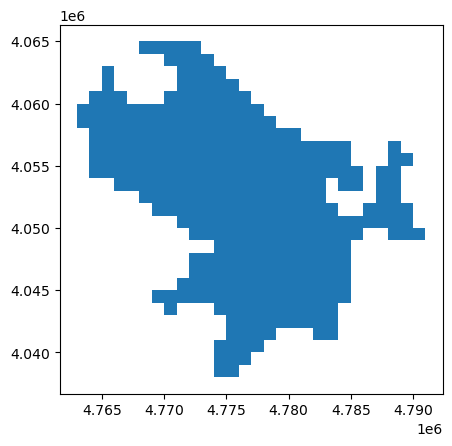

In [9]:
urban_center.plot()

In [23]:
urbc_ua = gpd.overlay(urban_center, ua, how='intersection')
urbc_ua

Q:\UserTemp\ubach\AppData\Local\Temp\22\ipykernel_9004\2569288596.py:1: UserWarning: `keep_geom_type=True` in overlay resulted in 93 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  urbc_ua = gpd.overlay(urban_center, ua, how='intersection')


,HDENS_CLST,HDENS_NAME,HDENS_2011,POPL_2021,CNTR_CODE,MBRS_CODE_,SHAPE_AREA,SHAPE_LEN,Batch,Area_ha,code_2018,Pop2018,original_area_m2,geometry
0,GEOSTAT21_018,Stockholm,GEOSTAT11_018,1462910.0,SE,1,342000000.0,162000.0,1.0,34200.0,12220,0,1.003986e+08,"MULTIPOLYGON (((4765654.049 4054019.723, 47656..."
1,GEOSTAT21_018,Stockholm,GEOSTAT11_018,1462910.0,SE,1,342000000.0,162000.0,1.0,34200.0,50000,0,2.646100e+08,"MULTIPOLYGON (((4791000.000 4049223.665, 47909..."
2,GEOSTAT21_018,Stockholm,GEOSTAT11_018,1462910.0,SE,1,342000000.0,162000.0,1.0,34200.0,11230,179,3.151949e+04,"POLYGON ((4778546.141 4045162.128, 4778553.258..."
3,GEOSTAT21_018,Stockholm,GEOSTAT11_018,1462910.0,SE,1,342000000.0,162000.0,1.0,34200.0,11210,166,1.303517e+04,"POLYGON ((4778488.625 4045179.246, 4778488.999..."
4,GEOSTAT21_018,Stockholm,GEOSTAT11_018,1462910.0,SE,1,342000000.0,162000.0,1.0,34200.0,11230,126,2.507621e+04,"POLYGON ((4778304.325 4045118.952, 4778255.638..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10597,GEOSTAT21_018,Stockholm,GEOSTAT11_018,1462910.0,SE,1,342000000.0,162000.0,1.0,34200.0,11220,201,1.017998e+04,"POLYGON ((4765126.116 4060542.913, 4765140.858..."
10598,GEOSTAT21_018,Stockholm,GEOSTAT11_018,1462910.0,SE,1,342000000.0,162000.0,1.0,34200.0,11230,41,1.378612e+04,"POLYGON ((4764656.188 4060472.862, 4764609.848..."
10599,GEOSTAT21_018,Stockholm,GEOSTAT11_018,1462910.0,SE,1,342000000.0,162000.0,1.0,34200.0,12100,9,9.415730e+03,"POLYGON ((4765452.391 4060474.169, 4765446.715..."
10600,GEOSTAT21_018,Stockholm,GEOSTAT11_018,1462910.0,SE,1,342000000.0,162000.0,1.0,34200.0,11230,132,1.660952e+04,"POLYGON ((4764945.308 4060516.733, 4764783.730..."


In [24]:
urbc_ua.Pop2018.sum()

1380871

In [27]:
urbc_ua.geometry.area.sum()/10000

33491.44754979972

In [25]:
urban_center

,HDENS_CLST,HDENS_NAME,HDENS_2011,POPL_2021,CNTR_CODE,MBRS_CODE_,SHAPE_AREA,SHAPE_LEN,Batch,Area_ha,geometry
0,GEOSTAT21_018,Stockholm,GEOSTAT11_018,1462910.0,SE,1,342000000.0,162000.0,1.0,34200.0,"POLYGON ((4775000.000 4038000.000, 4774000.000..."


In [10]:
urbc_agl = gpd.overlay(urban_center, agls, how='intersection')
urbc_agl

,HDENS_CLST,HDENS_NAME,HDENS_2011,POPL_2021,CNTR_CODE,MBRS_CODE_,SHAPE_AREA,SHAPE_LEN,Batch,Area_ha,agglomerationId_identifier,agglomerationName_nameEng,geometry
0,GEOSTAT21_018,Stockholm,GEOSTAT11_018,1462910.0,SE,1,342000000.0,162000.0,1.0,34200.0,SE_a_ag0126,Huddinge,"MULTIPOLYGON (((4774000.000 4038000.000, 47740..."
1,GEOSTAT21_018,Stockholm,GEOSTAT11_018,1462910.0,SE,1,342000000.0,162000.0,1.0,34200.0,SE_a_ag0180,Stockholm,"MULTIPOLYGON (((4771000.000 4044000.000, 47710..."
2,GEOSTAT21_018,Stockholm,GEOSTAT11_018,1462910.0,SE,1,342000000.0,162000.0,1.0,34200.0,SE_a_ag0182,Nacka,"MULTIPOLYGON (((4786000.000 4051000.000, 47860..."


<AxesSubplot: >

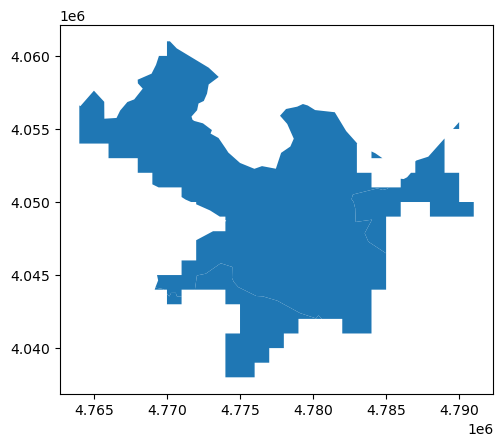

In [12]:
urbc_agl.plot()

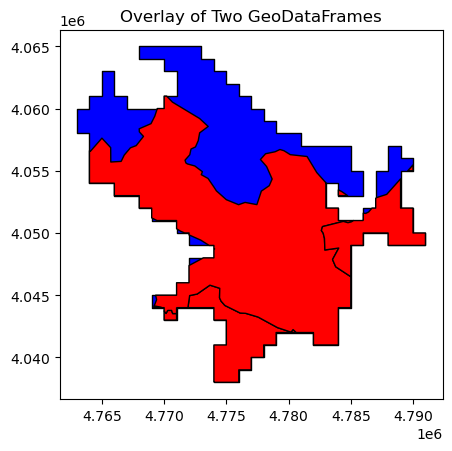

In [13]:
import geopandas as gpd
import matplotlib.pyplot as plt


# Plot both GeoDataFrames on the same axis
fig, ax = plt.subplots()

# Plot the first GeoDataFrame
urban_center.plot(ax=ax, color='blue', edgecolor='black')

# Plot the second GeoDataFrame
urbc_agl.plot(ax=ax, color='red', edgecolor='black')

# Add title and labels
ax.set_title('Overlay of Two GeoDataFrames')
plt.show()


In [19]:
urban_center.geometry.area.sum()

342000000.00000554

In [20]:
urbc_agl.geometry.area.sum()

231629202.80294368

In [21]:
urbc_agl.geometry.area.sum()/urban_center.geometry.area.sum()*100

67.72783707688302

In [22]:
urbc_agl

,HDENS_CLST,HDENS_NAME,HDENS_2011,POPL_2021,CNTR_CODE,MBRS_CODE_,SHAPE_AREA,SHAPE_LEN,Batch,Area_ha,agglomerationId_identifier,agglomerationName_nameEng,geometry
0,GEOSTAT21_018,Stockholm,GEOSTAT11_018,1462910.0,SE,1,342000000.0,162000.0,1.0,34200.0,SE_a_ag0126,Huddinge,"MULTIPOLYGON (((4774000.000 4038000.000, 47740..."
1,GEOSTAT21_018,Stockholm,GEOSTAT11_018,1462910.0,SE,1,342000000.0,162000.0,1.0,34200.0,SE_a_ag0180,Stockholm,"MULTIPOLYGON (((4771000.000 4044000.000, 47710..."
2,GEOSTAT21_018,Stockholm,GEOSTAT11_018,1462910.0,SE,1,342000000.0,162000.0,1.0,34200.0,SE_a_ag0182,Nacka,"MULTIPOLYGON (((4786000.000 4051000.000, 47860..."


In [19]:
SA_ls2

['P:\\Environment and Health\\Noise\\ServiceContract\\2024_ServiceContract\\QuietAreas\\OutputData\\SA\\GEOSTAT21_022_SA.shp',
 'P:\\Environment and Health\\Noise\\ServiceContract\\2024_ServiceContract\\QuietAreas\\OutputData\\SA\\GEOSTAT21_018_SA.shp',
 'P:\\Environment and Health\\Noise\\ServiceContract\\2024_ServiceContract\\QuietAreas\\OutputData\\SA\\GEOSTAT21_706_SA.shp']

In [20]:
cities_ls3=[]
for sa_name in SA_ls2:
    uc_code = os.path.basename(sa_name)[:-7]
    print (uc_code)

GEOSTAT21_022
GEOSTAT21_018
GEOSTAT21_706


In [23]:
cities_ls3=[]
for sa_name in SA_ls2:
    uc_code = os.path.basename(sa_name)[:-7]
    if uc_code not in cities_ls3:
        print (uc_code)
        SA = gpd.read_file(sa_name)
        SA.loc[:, 'FID_GQA'] = SA['Name'].str.split(":").str[0]
        uc_name = codes.query(f'HDENS_CLST=="{uc_code}"').HDENS_NAME.values[0]
        print(f'{uc_name} {uc_code}')
        print(str(datetime.now()))
    

GEOSTAT21_022
Örebro GEOSTAT21_022
2024-09-12 11:32:47.477015
GEOSTAT21_018
Stockholm GEOSTAT21_018
2024-09-12 11:32:51.487057
GEOSTAT21_706
Porto GEOSTAT21_706
2024-09-12 11:32:52.025087


In [16]:
cities_ls2

['GEOSTAT21_022', 'GEOSTAT21_018', 'GEOSTAT21_706']

In [ ]:
PercGreenQuietArea = TotalGreenQuietAreaHa/(TotalGreenAreaHa-green_excludedHa)*100
TotalGreen_urbc_ncm

In [1]:
codes.query('HDENS_CLST=="GEOSTAT21_350"')

NameError: name 'codes' is not defined

In [23]:
filtered_df = codes[~codes['UA2018'].str.contains('_UA2018_v013')]
filtered_df

,FREQUENCY,HDENS_CLST,HDENS_NAME,HDENS_2011,agglomerationId_identifier,agglomerationName_nameEng,UA2018
80,1,GEOSTAT21_211,Braunschweig,GEOSTAT11_211,AG_DE_NI_2,Brunswick,DE083L1_BRAUNSCHWEIG
108,1,GEOSTAT21_295,Halle an der Saale,GEOSTAT11_295,AG_DE_ST_1,Halle (Saale),DE018L1_HALLE_AN_DER_
140,1,GEOSTAT21_331,Mönchengladbach,GEOSTAT11_331,AG_DE_NW_12,Moenchengladbach,DE036L0_MONCHENGLADBACH
211,1,GEOSTAT21_425,Mannheim/Ludwigshafen,GEOSTAT11_425,AG_DE_BW_2,Mannheim,DE084L1_MANNHEIM_LUDWIGSHAFEN
212,1,GEOSTAT21_425,Mannheim/Ludwigshafen,GEOSTAT11_425,AG_DE_RP_1,Ludwigshafen,DE084L1_MANNHEIM_LUDWIGSHAFEN
250,1,GEOSTAT21_488,Freiburg im Breisgau,GEOSTAT11_488,AG_DE_BW_4,Freiburg,DE027L1_FREIBURG_IM_BREISGAU
273,1,GEOSTAT21_531,Fribourg,GEOSTAT11_531,AG_CH_00_11,Fribourg,not available
287,1,GEOSTAT21_558,Clermont-Ferrand,GEOSTAT11_558,AG_FR_00_11,Clermont-Ferrand,FR022L2_CLERMONT_FERRAND_UA2018
300,1,GEOSTAT21_590,Drobeta-Turnu Severin,GEOSTAT11_590,AG_RO_00_23,Drobeta-Turnu Severin,RO513L1_DROBETA_TURNU_SEVERIN
399,1,GEOSTAT21_800,Castellón de la Plana/Castelló de la Plana,GEOSTAT11_800,AG_ES_52_12040,Castellón de la Plana,ES520L1_CASTELLON_CASTELLO


In [20]:
ua_path

'DE036L0_MONCHENGLADBACH'

In [19]:
file_path

'A:\\Copernicus\\UrbanAtlas\\UrbanAtlas\\UA2018\\DE036L0_MONCHENGLADBACH\\Data\\DE036L0_MONCHENGLADBACH.gpkg'

In [18]:
SA_GQA_urbc

,unique_id,total_area_m2,FID_GQA_count,FID_GQA_first,HDENS_CLST,HDENS_NAME,HDENS_2011,POPL_2021,CNTR_CODE,MBRS_CODE_,SHAPE_AREA,SHAPE_LEN,Batch,geometry
0,0,152467.185051,1,0,GEOSTAT21_331,Mönchengladbach,GEOSTAT11_331,200219.0,DE,1,56000000.0,42000.0,2.0,"POLYGON ((4073184.630 3118180.602, 4073182.074..."
1,1,381473.546462,2,1,GEOSTAT21_331,Mönchengladbach,GEOSTAT11_331,200219.0,DE,1,56000000.0,42000.0,2.0,"MULTIPOLYGON (((4072830.255 3119008.727, 40728..."
2,2,531459.796239,3,1,GEOSTAT21_331,Mönchengladbach,GEOSTAT11_331,200219.0,DE,1,56000000.0,42000.0,2.0,"POLYGON ((4072460.255 3119063.727, 4072460.255..."
3,3,381473.546462,2,1,GEOSTAT21_331,Mönchengladbach,GEOSTAT11_331,200219.0,DE,1,56000000.0,42000.0,2.0,"POLYGON ((4072370.255 3119223.727, 4072385.255..."
4,4,381473.546462,2,1,GEOSTAT21_331,Mönchengladbach,GEOSTAT11_331,200219.0,DE,1,56000000.0,42000.0,2.0,"POLYGON ((4072215.255 3119078.727, 4072212.755..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3805,3967,406586.102865,2,96,GEOSTAT21_331,Mönchengladbach,GEOSTAT11_331,200219.0,DE,1,56000000.0,42000.0,2.0,"POLYGON ((4071946.045 3128708.990, 4071950.255..."
3806,3968,406586.102865,2,96,GEOSTAT21_331,Mönchengladbach,GEOSTAT11_331,200219.0,DE,1,56000000.0,42000.0,2.0,"POLYGON ((4071965.255 3128649.977, 4071965.255..."
3807,3969,530311.319865,3,96,GEOSTAT21_331,Mönchengladbach,GEOSTAT11_331,200219.0,DE,1,56000000.0,42000.0,2.0,"POLYGON ((4072130.255 3128373.727, 4072130.192..."
3808,3970,123725.217000,1,98,GEOSTAT21_331,Mönchengladbach,GEOSTAT11_331,200219.0,DE,1,56000000.0,42000.0,2.0,"POLYGON ((4072835.880 3128893.727, 4072835.255..."


In [ ]:


# Column name to check
column_name = 'C'

# Check if column does not exist
if column_name not in df.columns:
    print(f"'{column_name}' does not exist in the DataFrame.")
else:
    print(f"'{column_name}' exists in the DataFrame.")

In [16]:
SA_GQA_ua

,unique_id,total_area_m2,FID_GQA_count,FID_GQA_first,HDENS_CLST,HDENS_NAME,HDENS_2011,POPL_2021,CNTR_CODE,MBRS_CODE_,SHAPE_AREA,SHAPE_LEN,Batch,code_2018,Pop2018,original_area_m2,geometry
0,1,271959.241160,3,0,GEOSTAT21_128,Bydgoszcz,GEOSTAT11_128,244321.0,PL,2,46000000.0,40000.0,2.0,31000,0,8188648.26,"POLYGON ((4858639.595 3361007.919, 4858638.237..."
1,3,251149.923764,2,0,GEOSTAT21_128,Bydgoszcz,GEOSTAT11_128,244321.0,PL,2,46000000.0,40000.0,2.0,31000,0,8188648.26,"POLYGON ((4858086.405 3361000.000, 4858086.405..."
2,15,251149.923764,2,0,GEOSTAT21_128,Bydgoszcz,GEOSTAT11_128,244321.0,PL,2,46000000.0,40000.0,2.0,31000,0,8188648.26,"POLYGON ((4858086.405 3361000.000, 4858086.405..."
3,17,585827.662734,3,1,GEOSTAT21_128,Bydgoszcz,GEOSTAT11_128,244321.0,PL,2,46000000.0,40000.0,2.0,31000,0,8188648.26,"MULTIPOLYGON (((4858695.695 3361337.680, 48586..."
4,18,252015.314385,2,1,GEOSTAT21_128,Bydgoszcz,GEOSTAT11_128,244321.0,PL,2,46000000.0,40000.0,2.0,31000,0,8188648.26,"POLYGON ((4858668.026 3361052.294, 4858668.026..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3486,1604,110598.098311,1,85,GEOSTAT21_128,Bydgoszcz,GEOSTAT11_128,244321.0,PL,2,46000000.0,40000.0,2.0,11100,167,19903.28,"MULTIPOLYGON (((4849568.026 3367977.294, 48495..."
3487,1604,110598.098311,1,85,GEOSTAT21_128,Bydgoszcz,GEOSTAT11_128,244321.0,PL,2,46000000.0,40000.0,2.0,11100,62,6828.17,"POLYGON ((4849398.026 3367767.294, 4849388.026..."
3488,1604,110598.098311,1,85,GEOSTAT21_128,Bydgoszcz,GEOSTAT11_128,244321.0,PL,2,46000000.0,40000.0,2.0,11100,54,6420.61,"POLYGON ((4849407.885 3367765.003, 4849393.281..."
3489,1604,110598.098311,1,85,GEOSTAT21_128,Bydgoszcz,GEOSTAT11_128,244321.0,PL,2,46000000.0,40000.0,2.0,12100,11,27825.02,"POLYGON ((4849398.026 3367977.294, 4849443.026..."


In [16]:
urban_center

,HDENS_CLST,HDENS_NAME,HDENS_2011,POPL_2021,CNTR_CODE,MBRS_CODE_,SHAPE_AREA,SHAPE_LEN,Batch,geometry
167,GEOSTAT21_363,Bonn,GEOSTAT11_363,522767.0,DE,1,189000000.0,94000.0,1.0,"POLYGON ((4124000.000 3064000.000, 4122000.000..."


In [15]:
uc_code

'GEOSTAT21_363'

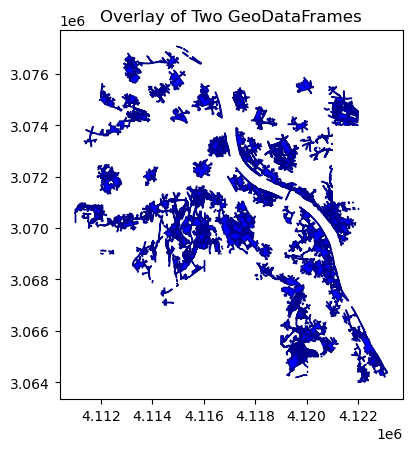

In [21]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load your GeoDataFrames


# Plot both GeoDataFrames on the same axis
fig, ax = plt.subplots()

# Plot the first GeoDataFrame
SA_GQA_urbc.plot(ax=ax, color='blue', edgecolor='darkblue')


# Add title and labels
ax.set_title('Overlay of Two GeoDataFrames')
plt.show()

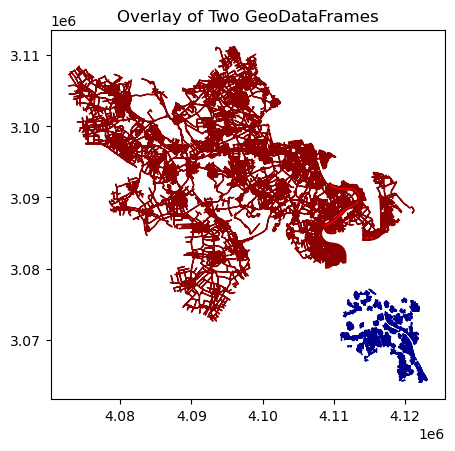

In [23]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load your GeoDataFrames


# Plot both GeoDataFrames on the same axis
fig, ax = plt.subplots()

# Plot the first GeoDataFrame
SA_GQA_urbc.plot(ax=ax, color='blue', edgecolor='darkblue')

# Plot the second GeoDataFrame
ua.plot(ax=ax, color='red', edgecolor='darkred')

# Add title and labels
ax.set_title('Overlay of Two GeoDataFrames')
plt.show()


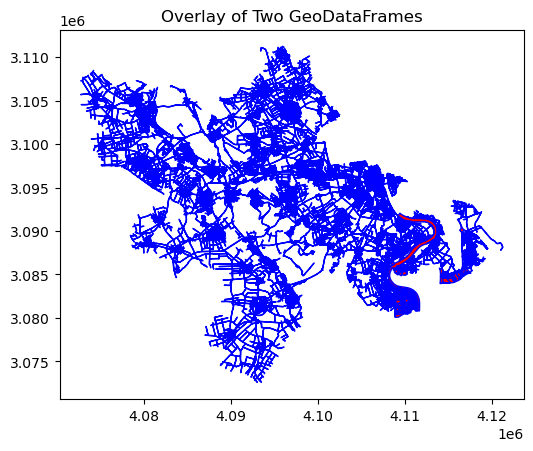

In [19]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load your GeoDataFrames


# Plot both GeoDataFrames on the same axis
fig, ax = plt.subplots()

# Plot the second GeoDataFrame
ua.plot(ax=ax, color='red', edgecolor='blue')

# Add title and labels
ax.set_title('Overlay of Two GeoDataFrames')
plt.show()

In [14]:
gpd.overlay(SA_GQA_urbc,ua,how='intersection') 


,unique_id,total_area,FID_GQA_co,FID_GQA_fi,HDENS_CLST,HDENS_NAME,HDENS_2011,POPL_2021,CNTR_CODE,MBRS_CODE_,SHAPE_AREA,SHAPE_LEN,Batch,code_2018,Pop2018,original_area_m2,geometry


In [13]:
ua

,code_2018,Pop2018,geometry,original_area_m2
0,12220,0,"MULTIPOLYGON (((4074785.025 3098821.498, 40747...",30285780.31
1,21000,13,"MULTIPOLYGON (((4109841.483 3080427.359, 41098...",455788.15
2,11100,131,"MULTIPOLYGON (((4114574.410 3085000.000, 41145...",30502.36
3,11100,132,"MULTIPOLYGON (((4114844.029 3084869.393, 41148...",25691.25
4,11100,136,"MULTIPOLYGON (((4114744.712 3085000.000, 41147...",25102.50
...,...,...,...,...
240,14100,0,"MULTIPOLYGON (((4114652.278 3084698.261, 41146...",7933.11
241,21000,24,"MULTIPOLYGON (((4115004.638 3084699.761, 41149...",81823.98
242,11210,51,"MULTIPOLYGON (((4114928.973 3085256.555, 41149...",14031.54
243,32000,0,"MULTIPOLYGON (((4115549.033 3085006.952, 41155...",17420.03


In [12]:
SA_GQA_urbc

,unique_id,total_area,FID_GQA_co,FID_GQA_fi,HDENS_CLST,HDENS_NAME,HDENS_2011,POPL_2021,CNTR_CODE,MBRS_CODE_,SHAPE_AREA,SHAPE_LEN,Batch,geometry
0,0,280139.027054,3,0,GEOSTAT21_363,Bonn,GEOSTAT11_363,522767.0,DE,1,189000000.0,94000.0,1.0,"POLYGON ((4122260.811 3064368.727, 4122270.255..."
1,1,344843.530783,4,0,GEOSTAT21_363,Bonn,GEOSTAT11_363,522767.0,DE,1,189000000.0,94000.0,1.0,"POLYGON ((4122285.255 3064313.727, 4122255.255..."
2,2,280139.027054,3,0,GEOSTAT21_363,Bonn,GEOSTAT11_363,522767.0,DE,1,189000000.0,94000.0,1.0,"POLYGON ((4122259.346 3064403.727, 4122270.255..."
3,3,344843.530783,4,0,GEOSTAT21_363,Bonn,GEOSTAT11_363,522767.0,DE,1,189000000.0,94000.0,1.0,"POLYGON ((4122255.255 3064368.727, 4122245.255..."
4,4,280139.027054,3,0,GEOSTAT21_363,Bonn,GEOSTAT11_363,522767.0,DE,1,189000000.0,94000.0,1.0,"POLYGON ((4122268.755 3064396.227, 4122270.255..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6311,6882,396673.933859,3,95,GEOSTAT21_363,Bonn,GEOSTAT11_363,522767.0,DE,1,189000000.0,94000.0,1.0,"POLYGON ((4115218.589 3070818.727, 4115220.255..."
6312,6883,396673.933859,3,95,GEOSTAT21_363,Bonn,GEOSTAT11_363,522767.0,DE,1,189000000.0,94000.0,1.0,"POLYGON ((4115375.255 3070973.727, 4115376.409..."
6313,6884,396673.933859,3,95,GEOSTAT21_363,Bonn,GEOSTAT11_363,522767.0,DE,1,189000000.0,94000.0,1.0,"POLYGON ((4115360.255 3070993.727, 4115350.255..."
6314,6885,257784.102800,1,95,GEOSTAT21_363,Bonn,GEOSTAT11_363,522767.0,DE,1,189000000.0,94000.0,1.0,"POLYGON ((4115131.424 3069966.391, 4115119.444..."


In [11]:
SA_GQA_ua

,unique_id,total_area,FID_GQA_co,FID_GQA_fi,HDENS_CLST,HDENS_NAME,HDENS_2011,POPL_2021,CNTR_CODE,MBRS_CODE_,SHAPE_AREA,SHAPE_LEN,Batch,code_2018,Pop2018,original_area_m2,geometry


In [34]:
result_erase_FIDs_left.columns

Index(['area', 'unique_id', 'geometry', 'index_right', 'FID_GQA', 'area_m2'], dtype='object')

In [35]:
SA_GQA_total2 = result_erase_FIDs_left.dissolve(by='unique_id', aggfunc={'area_m2': 'sum', 'FID_GQA': ['count', 'first']})

In [37]:
SA_GQA_total2.reset_index(inplace=True)

In [39]:
SA_GQA_total2

,unique_id,geometry,"(area_m2, sum)","(FID_GQA, count)","(FID_GQA, first)"
0,0,"POLYGON ((3274411.891 2327414.402, 3274426.911...",222846.338025,2,0
1,1,"POLYGON ((3274427.581 2327409.919, 3274441.581...",222846.338025,2,0
2,2,"POLYGON ((3274402.581 2327417.062, 3274385.706...",222846.338025,2,0
3,3,"POLYGON ((3274411.891 2327414.402, 3274407.581...",222846.338025,2,0
4,4,"POLYGON ((3274392.581 2327419.919, 3274385.706...",222846.338025,2,0
...,...,...,...,...,...
2425,2425,"POLYGON ((3275268.037 2328007.008, 3275269.964...",492347.168897,2,8
2426,2426,"POLYGON ((3275300.662 2328096.198, 3275298.494...",492347.168897,2,8
2427,2427,"POLYGON ((3275307.581 2327914.919, 3275303.831...",277289.232868,1,8
2428,2428,"POLYGON ((3275091.685 2327963.127, 3275090.800...",277289.232868,1,8


In [32]:
SA_GQA_urbc.columns

Index(['unique_id', 'total_area', 'FID_GQA_co', 'FID_GQA_fi', 'HDENS_CLST',
       'HDENS_NAME', 'HDENS_2011', 'POPL_2021', 'CNTR_CODE', 'MBRS_CODE_',
       'SHAPE_AREA', 'SHAPE_LEN', 'Batch', 'geometry'],
      dtype='object')

In [31]:
SA_GQA_ua.columns

Index(['unique_id', 'total_area', 'FID_GQA_co', 'FID_GQA_fi', 'HDENS_CLST',
       'HDENS_NAME', 'HDENS_2011', 'POPL_2021', 'CNTR_CODE', 'MBRS_CODE_',
       'SHAPE_AREA', 'SHAPE_LEN', 'Batch', 'code_2018', 'Pop2018',
       'original_area_m2', 'geometry'],
      dtype='object')

In [33]:
SA_final.columns

Index(['FID_GQA', 'geometry', 'area_m2'], dtype='object')

In [30]:
SA_GQA_total.columns

Index(['unique_id', 'geometry', 'total_area_m2', 'FID_GQA_count',
       'FID_GQA_first'],
      dtype='object')

In [19]:
outtbl = pd.read_csv(csv_path)
cities_ls = outtbl.uc_code.to_list()

In [21]:
if 'GEOSTAT21_006' in cities_ls:
    print('in')
else:
    print('out')

out


In [8]:
codes.head()

,FREQUENCY,HDENS_CLST,HDENS_NAME,HDENS_2011,agglomerationId_identifier,agglomerationName_nameEng,UA2018
0,1,GEOSTAT21_002,Oulu / Uleåborg,GEOSTAT11_002,AG_FI_00_6,Oulu,FI004L4_OULU_UA2018_v013
1,1,GEOSTAT21_003,Umeå,GEOSTAT11_003,SE_a_ag2480,Umea,SE005L1_UMEA_UA2018_v013
2,1,GEOSTAT21_004,Trondheim,GEOSTAT11_004,AG_NO_00_3,Trondheim,NO003L1_TRONDHEIM_UA2018_v013
3,1,GEOSTAT21_005,Jyväskylä,GEOSTAT11_005,AG_FI_00_9,Jyvaskyla,FI009L2_JYVASKYLA_UA2018_v013
4,1,GEOSTAT21_006,Tampere / Tammerfors,GEOSTAT11_006,AG_FI_00_3,Tampere,FI002L3_TAMPERE_UA2018_v013


In [10]:
codes.query('HDENS_NAME=="Bilbao"')

,FREQUENCY,HDENS_CLST,HDENS_NAME,HDENS_2011,agglomerationId_identifier,agglomerationName_nameEng,UA2018
324,1,GEOSTAT21_650,Bilbao,GEOSTAT11_650,AG_ES_21_48013,Barakaldo,ES019L3_BILBAO_UA2018_v013\r\r\n
325,1,GEOSTAT21_650,Bilbao,GEOSTAT11_650,AG_ES_21_48020,Bilbao,ES019L3_BILBAO_UA2018_v013\r\r\n


In [14]:
codes.query('HDENS_NAME=="Bilbao"').UA2018.values[0].strip()

'ES019L3_BILBAO_UA2018_v013'

In [52]:
ua_path[:-5]

'IE001L1_DUBLIN_UA2018'

In [53]:
SA_GQA_urbc

,unique_id,total_area_m2,FID_GQA_count,FID_GQA_first,HDENS_CLST,HDENS_NAME,HDENS_2011,POPL_2021,CNTR_CODE,MBRS_CODE_,SHAPE_AREA,SHAPE_LEN,Batch,geometry
0,0,1.095625e+05,2,0,GEOSTAT21_905,Utrecht,None,346992.0,NL,1,58000000.0,42000.0,1.0,"POLYGON ((3987462.287 3227333.752, 3987457.287..."
1,1,1.095625e+05,2,0,GEOSTAT21_905,Utrecht,None,346992.0,NL,1,58000000.0,42000.0,1.0,"POLYGON ((3987393.169 3227338.262, 3987387.287..."
2,2,1.095625e+05,2,0,GEOSTAT21_905,Utrecht,None,346992.0,NL,1,58000000.0,42000.0,1.0,"POLYGON ((3987457.287 3227334.085, 3987457.287..."
3,3,1.095625e+05,2,0,GEOSTAT21_905,Utrecht,None,346992.0,NL,1,58000000.0,42000.0,1.0,"POLYGON ((3987393.169 3227338.262, 3987385.014..."
4,4,1.095625e+05,2,0,GEOSTAT21_905,Utrecht,None,346992.0,NL,1,58000000.0,42000.0,1.0,"POLYGON ((3987380.923 3227306.934, 3987382.287..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6207,6309,7.388210e+05,3,77,GEOSTAT21_905,Utrecht,None,346992.0,NL,1,58000000.0,42000.0,1.0,"POLYGON ((3979862.287 3232288.752, 3979852.287..."
6208,6310,7.388210e+05,3,77,GEOSTAT21_905,Utrecht,None,346992.0,NL,1,58000000.0,42000.0,1.0,"POLYGON ((3979631.176 3232084.307, 3979632.287..."
6209,6311,7.388210e+05,3,77,GEOSTAT21_905,Utrecht,None,346992.0,NL,1,58000000.0,42000.0,1.0,"POLYGON ((3979607.287 3232088.752, 3979612.287..."
6210,6312,7.388210e+05,3,77,GEOSTAT21_905,Utrecht,None,346992.0,NL,1,58000000.0,42000.0,1.0,"POLYGON ((3979622.287 3232058.752, 3979627.287..."


In [ ]:
# Check if the file exists to determine if headers need to be written
file_exists = os.path.isfile(log_path)

# Open the log file in append mode
with open(log_path, 'a', newline='') as csvfile:
    log_writer = csv.writer(csvfile)

    # Write the header if the file is new
    if not file_exists:
        log_writer.writerow(['Timestamp', 'HDENS_NAME', 'agglo_Id', 'uc_km2', 'gdf2_km2', 'gdf1_gdf2_km2', 
                                'ua_km2', 'uagreen_km2', 'uagreen_urbc_km2', 'nqgreen_m2', 'green_not_covered_by_gdf1_m2',
                                'GQA_m2', 'GNA_m2', 'prDuration'])

    # Write the log entry
    log_writer.writerow(log_entry)
write_log(csv_path, log_entry)

In [40]:
del TotalPop
if TotalPop is None:
    print ('hello')

NameError: name 'TotalPop' is not defined

In [38]:
SA_GQA_ua.head()
#KeyError: "['original_area_m2'] not in index"
##SA_GQA_ua = SA_GQA_ua[['unique_id', 'total_area_m2','code_2018',  'Pop2018','original_area_m2',  'geometry']]

,unique_id,total_area_m2,FID_GQA_count,FID_GQA_first,HDENS_CLST,HDENS_NAME,HDENS_2011,POPL_2021,CNTR_CODE,MBRS_CODE_,SHAPE_AREA,SHAPE_LEN,Batch,code_2018,Pop2018,geometry
0,0,109562.465962,2,0,GEOSTAT21_905,Utrecht,None,346992.0,NL,1,58000000.0,42000.0,1.0,14100,0,"POLYGON ((3987457.287 3227334.085, 3987457.287..."
1,1,109562.465962,2,0,GEOSTAT21_905,Utrecht,None,346992.0,NL,1,58000000.0,42000.0,1.0,14100,0,"POLYGON ((3987387.287 3227338.752, 3987385.014..."
2,2,109562.465962,2,0,GEOSTAT21_905,Utrecht,None,346992.0,NL,1,58000000.0,42000.0,1.0,14100,0,"POLYGON ((3987457.287 3227333.752, 3987447.287..."
3,3,109562.465962,2,0,GEOSTAT21_905,Utrecht,None,346992.0,NL,1,58000000.0,42000.0,1.0,14100,0,"POLYGON ((3987385.014 3227327.388, 3987387.287..."
4,22,109562.465962,2,0,GEOSTAT21_905,Utrecht,None,346992.0,NL,1,58000000.0,42000.0,1.0,14100,0,"POLYGON ((3987637.287 3227363.752, 3987637.287..."


In [21]:
codes.head()

,FREQUENCY,HDENS_CLST,HDENS_NAME,HDENS_2011,agglomerationId_identifier,agglomerationName_nameEng,UA2018
0,1,GEOSTAT21_002,Oulu / Uleåborg,GEOSTAT11_002,AG_FI_00_6,Oulu,FI004L4_OULU_UA2018_v013
1,1,GEOSTAT21_003,Umeå,GEOSTAT11_003,SE_a_ag2480,Umea,SE005L1_UMEA_UA2018_v013
2,1,GEOSTAT21_004,Trondheim,GEOSTAT11_004,AG_NO_00_3,Trondheim,NO003L1_TRONDHEIM_UA2018_v013
3,1,GEOSTAT21_005,Jyväskylä,GEOSTAT11_005,AG_FI_00_9,Jyvaskyla,FI009L2_JYVASKYLA_UA2018_v013
4,1,GEOSTAT21_006,Tampere / Tammerfors,GEOSTAT11_006,AG_FI_00_3,Tampere,FI002L3_TAMPERE_UA2018_v013


In [ ]:
# select a subset of columns
SA_final = SA_final[['FID_GQA',
 'area_m2',
 'area_ha',
 'geometry']]

In [57]:
SA_final

,FID_GQA,geometry,FacilityID,Name,FromBreak,ToBreak,Shape_Leng,Shape_Area
0,0,"MULTIPOLYGON (((4651382.019 3931912.035, 46513...",2,0 : 0 - 400,0.0,400.0,1941.127601,28987.5
1,1,"POLYGON ((4653962.019 3932312.035, 4653992.019...",4,1 : 0 - 400,0.0,400.0,3535.222551,124375.0
2,10,"POLYGON ((4652766.093 3932514.072, 4652762.019...",102,10 : 0 - 400,0.0,400.0,4048.773240,163637.5
3,100,"MULTIPOLYGON (((4650402.019 3934512.035, 46504...",1076,100 : 0 - 400,0.0,400.0,5042.758993,137612.5
4,101,"MULTIPOLYGON (((4651642.019 3934842.035, 46516...",1092,101 : 0 - 400,0.0,400.0,6021.435962,174962.5
...,...,...,...,...,...,...,...,...
170,95,"MULTIPOLYGON (((4650261.539 3934545.112, 46502...",1015,95 : 0 - 400,0.0,400.0,4754.873273,79812.5
171,96,"MULTIPOLYGON (((4652817.696 3934168.944, 46528...",1025,96 : 0 - 400,0.0,400.0,4341.821693,145837.5
172,97,"POLYGON ((4651516.230 3934668.351, 4651473.894...",1038,97 : 0 - 400,0.0,400.0,3809.244825,93275.0
173,98,"MULTIPOLYGON (((4652892.019 3934462.035, 46528...",1052,98 : 0 - 400,0.0,400.0,4008.695050,97875.0


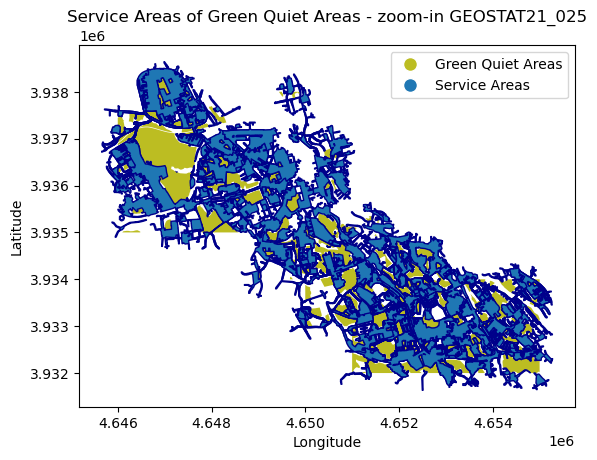

In [60]:
# Plot GQA
colors_ls = ['tab:olive', 'tab:blue']
ax = GQA.plot(facecolor=colors_ls[0], edgecolor='None', legend=True)

# Plot SAs
SA_final.plot(ax=ax, facecolor=colors_ls[1], edgecolor='darkblue', legend=True)

# Set the limits to zoom in on a specified region
#ax.set_ylim(2467000, 2468500)
#ax.set_xlim(3485000, 3487000)

# Set plot labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Service Areas of Green Quiet Areas - zoom-in {uc_code}')

# Show the legend with customized labels
legend_labels = {'Green Quiet Areas': 'Green Quiet Areas', 'Service Areas': 'Service Areas'}
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors_ls]
ax.legend(handles=handles, labels=legend_labels.values())

# Display the plot
plt.show()

In [6]:
 # Read all layers from the geodatabase
group_id = str(230)
ID_GROUP = "GROUP_" + group_id
SA = gpd.read_file(gdb_path, driver='FileGDB', layer=f"{ID_GROUP}_sa")

path = os.path.join(outPath, 'GUA_pt_ALL_GQA_FID.shp')  
pts_GQA_FID = gpd.read_file(path)

# select a subset of columns
pts_GQA_FID = pts_GQA_FID[['FID_GQA', 'country', 'fua_name','fua_code',
'HDENS_2011', 'code_2018', 'class_2018', 'noisy',
'area_m2', 'area_ha', 'area_km2']]

# Add green area information to the SA feature
SA_FID = SA.merge(pts_GQA_FID, left_index= True, right_index= True, how= 'left')

# Dissolve by GQA identifier
SA_FID_dis = SA_FID.dissolve('FID_GQA')
SA_FID_dis.reset_index(inplace=True)

# Save temporary file
file_path = os.path.join(outdata_f, 'SA_FID_dis.shp')
SA_FID_dis.to_file(file_path, driver='ESRI Shapefile')

Q:\UserTemp\ubach\AppData\Local\Temp\11\ipykernel_64008\2941010059.py:23: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  SA_FID_dis.to_file(file_path, driver='ESRI Shapefile')


#### Step 3: Erase those areas of SA overlaping the GreenUrban Areas

In [35]:
# Load QGA
path = os.path.join(outPath, 'GQA.shp')  
GQA = gpd.read_file(path)

# Remove QGA delineation from the SA
SA_final = gpd.overlay(SA_FID_dis, GQA, how='difference')

# Save temporary file
file_path = os.path.join(outdata_f, 'SA_final.shp')
SA_final.to_file(file_path, driver='ESRI Shapefile')

Q:\UserTemp\ubach\AppData\Local\Temp\11\ipykernel_64008\929151681.py:10: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  SA_final.to_file(file_path, driver='ESRI Shapefile')


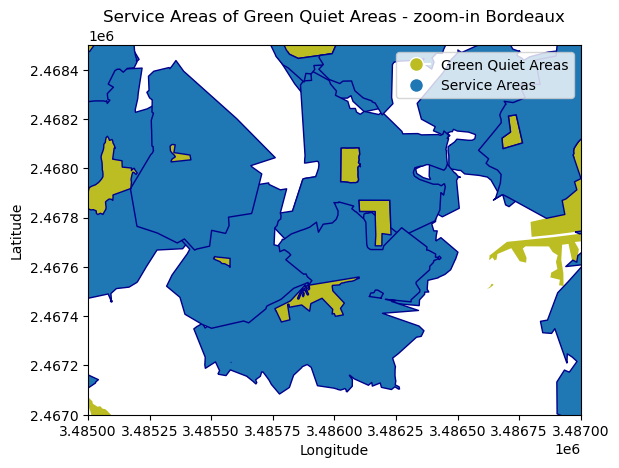

In [36]:
# Plot GQA
colors_ls = ['tab:olive', 'tab:blue']
ax = GQA.plot(facecolor=colors_ls[0], edgecolor='None', legend=True)

# Plot SAs
SA_final.plot(ax=ax, facecolor=colors_ls[1], edgecolor='darkblue', legend=True)

# Set the limits to zoom in on a specified region
ax.set_ylim(2467000, 2468500)
ax.set_xlim(3485000, 3487000)

# Set plot labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Service Areas of Green Quiet Areas - zoom-in Bordeaux')

# Show the legend with customized labels
legend_labels = {'Green Quiet Areas': 'Green Quiet Areas', 'Service Areas': 'Service Areas'}
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors_ls]
ax.legend(handles=handles, labels=legend_labels.values())

# Display the plot
plt.show()

#### Step 4: Calculate the portion of SA that intersect between each other (SA_final)

Some polygons from the service areas are intersecting with other service areas generated from different GQAs. This meaning some polygons overlap where different service areas coincide. To properly assign the amount of qreen quiet area with accessibility, we need to differentiate these areas and sum the number of areas from the different GQA that serves.

In [37]:
# select a subset of columns
SA_final = SA_final[['FID_GQA',
 'area_m2',
 'area_ha',
 'geometry']]

In [38]:
## Creating non-overlapping units following the proposed approach from:
## https://gis.stackexchange.com/questions/187402/how-to-find-the-intersection-areas-of-overlapping-buffer-zones-in-single-shapefi/187499#187499

# Split multipart polygons to single part polygons
SA_FID_mp = SA_final.explode(ignore_index=True)

# create unique features from input polygons
rings = [LineString(list(shape(geometry).exterior.coords)) for geometry in SA_FID_mp['geometry']]
union = unary_union(rings)
SA_no_overlaps = [geom for geom in polygonize(union)]

# Create a new GeoDataFrame for the result
SA_no_overlaps_gdf = gpd.GeoDataFrame(geometry=SA_no_overlaps)

# Add an 'area' column to the new GeoDataFrame
SA_no_overlaps_gdf['area'] = SA_no_overlaps_gdf['geometry'].area
SA_no_overlaps_gdf.crs = SA_FID_mp.crs

# remove again the GQA
SA_no_overlaps_gdf = gpd.overlay(SA_no_overlaps_gdf, GQA, how='difference')

# Add unique id field
SA_no_overlaps_gdf['unique_id'] = range(len(SA_no_overlaps_gdf))

# Save the result GeoDataFrame to shapefile
file_path = os.path.join(outdata_f, 'SA_no_overlaps.shp')
SA_no_overlaps_gdf.to_file(file_path, driver='ESRI Shapefile')

Q:\UserTemp\ubach\AppData\Local\Temp\11\ipykernel_64008\208558994.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_no_overlaps_gdf = gpd.overlay(SA_no_overlaps_gdf, GQA, how='difference')


In [39]:
result_erase_FIDs_left = gpd.sjoin(SA_no_overlaps_gdf, SA_final, how= 'left', op='intersects')
SA_GQA_total = result_erase_FIDs_left.dissolve(by='unique_id', aggfunc={'area_m2': 'sum', 'FID_GQA': ['count', 'first']})
SA_GQA_total.reset_index(inplace=True)
SA_GQA_total.columns = ['unique_id', 'geometry', 'total_area_m2', 'FID_GQA_count', 'FID_GQA_first']

c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\IPython\core\interactiveshell.py:3382: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [40]:
SA_GQA_total

,unique_id,geometry,total_area_m2,FID_GQA_count,FID_GQA_first
0,0,"POLYGON ((3485217.304 2475183.692, 3485252.234...",178770.002306,4,327
1,1,"POLYGON ((3485365.031 2474998.691, 3485383.825...",16265.322519,2,341
2,2,"POLYGON ((3485302.448 2474814.608, 3485311.259...",120007.896623,5,337
3,3,"POLYGON ((3484916.041 2474668.708, 3484904.215...",8126.677858,2,327
4,4,"POLYGON ((3484966.869 2474849.688, 3484952.669...",167987.200262,3,327
...,...,...,...,...,...
3333,3333,"POLYGON ((3486715.194 2474454.977, 3486676.845...",106263.749138,5,435
3334,3334,"POLYGON ((3486929.266 2474098.952, 3486931.607...",45479.516207,5,22
3335,3335,"POLYGON ((3482007.665 2471991.615, 3482010.723...",1696.530171,1,434
3336,3336,"POLYGON ((3486679.045 2473691.123, 3486679.114...",35007.298213,3,22


In [41]:
# Remove the outer areas from urban centers
# Load urban center delineation
path = os.path.join(indata_f, 'HDC2021_RG.shp')  
urban_center = gpd.read_file(path)
urban_center = urban_center.query('HDENS_NAME =="Bordeaux"')

# Remove QGA delineation from the SA
SA_GQA_urbc = gpd.overlay(SA_GQA_total, urban_center, how='intersection')
file_path = os.path.join(outdata_f, 'SA_GQA_urbc.shp')
SA_GQA_urbc.to_file(file_path, driver='ESRI Shapefile')

Q:\UserTemp\ubach\AppData\Local\Temp\11\ipykernel_64008\3705143651.py:7: UserWarning: `keep_geom_type=True` in overlay resulted in 83 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_GQA_urbc = gpd.overlay(SA_GQA_total, urban_center, how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\11\ipykernel_64008\3705143651.py:9: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  SA_GQA_urbc.to_file(file_path, driver='ESRI Shapefile')


#### Step 5: Final computations including population

Compute Total Green Areas

In [146]:
# Read Urban Atlas data
data_f = r'A:\Copernicus\UrbanAtlas\UrbanAtlas\UA2018'
file_path = os.path.join(data_f, r'FR007L2_BORDEAUX_UA2018_v013\Data\FR007L2_BORDEAUX_UA2018_v013.gpkg')

# Read the GeoPackage file
ua = gpd.read_file(file_path, layer='FR007L2_BORDEAUX_UA2018')

In [152]:
# Read shapefile
data_f = r'S:\Common workspace\ETC_DI\AP23_GreenQuietAreas\UrbanQuiet\Input'
file_path = os.path.join(data_f, 'HDC2021_RG.shp')

# Read the GeoPackage file
uc = gpd.read_file(file_path)

# Urban center for Bordeaux
uc_bdx = uc.query('HDENS_NAME == "Bordeaux"')

In [154]:
# urban green in all FUA
uagreen = ua.query('code_2018 == "14100" or code_2018 == "31000"')
# urban green within the Urban Center
uagreen_urbc = gpd.overlay(uagreen, uc_bdx, how='intersection')

In [148]:
ua.area.sum()*0.0001

555595.7914096091

In [145]:
uagreen.area.sum()*0.0001

275402.4806754545

In [155]:
uagreen_urbc.area.sum()*0.0001

1938.046991322812

In [150]:
GQA.area.sum()*0.0001

1105.4458778726878

In [66]:
uagreen_urbc.head()

,country,fua_name,fua_code,code_2018,class_2018,prod_date,identifier,perimeter,area,comment,...,FID_GQA_first,HDENS_CLST,HDENS_NAME,HDENS_2011,POPL_2021,CNTR_CODE,MBRS_CODE_,SHAPE_AREA,SHAPE_LEN,geometry
0,FR,Bordeaux,FR007L2,14100,Green urban areas,2020-01,41439-FR007L2,324.792007,5752.133073,None,...,327,GEOSTAT21_595,Bordeaux,GEOSTAT11_595,690408.0,FR,1,183000000.0,88000.0,"POLYGON ((3484981.105 2474871.035, 3484980.735..."
1,FR,Bordeaux,FR007L2,14100,Green urban areas,2020-01,41439-FR007L2,324.792007,5752.133073,None,...,327,GEOSTAT21_595,Bordeaux,GEOSTAT11_595,690408.0,FR,1,183000000.0,88000.0,"POLYGON ((3484977.002 2474874.618, 3484981.950..."
2,FR,Bordeaux,FR007L2,14100,Green urban areas,2020-01,41548-FR007L2,2869.748431,247101.268040,None,...,327,GEOSTAT21_595,Bordeaux,GEOSTAT11_595,690408.0,FR,1,183000000.0,88000.0,"POLYGON ((3484814.812 2475172.268, 3484814.790..."
3,FR,Bordeaux,FR007L2,14100,Green urban areas,2020-01,41090-FR007L2,167.670852,1843.689929,None,...,81,GEOSTAT21_595,Bordeaux,GEOSTAT11_595,690408.0,FR,1,183000000.0,88000.0,"POLYGON ((3484821.752 2468129.080, 3484821.678..."
4,FR,Bordeaux,FR007L2,14100,Green urban areas,2020-01,41102-FR007L2,482.098104,5404.861439,None,...,81,GEOSTAT21_595,Bordeaux,GEOSTAT11_595,690408.0,FR,1,183000000.0,88000.0,"POLYGON ((3484808.507 2468197.513, 3484815.016..."


In [157]:
# All green areas (GUAs and forests) in the urban center (including data outside the ncm)
TotalGreenArea = uagreen_urbc.geometry.area.sum()
TotalGreenAreaHa = TotalGreenArea/10000

Green areas excluded (areas not covered by ncm)

In [160]:
# Load the delineation for the agglomeration
# Read noise data
file_path = os.path.join(indata_f, 'NoiseData\Agglomerations-StrategicNoiseMaps-multipoly.gpkg')
# Read the GeoPackage file
ncm = gpd.read_file(file_path, layer='NoiseContours_roadsInAgglomeration_Lden')

# Read agglomerations delineations
file_path = os.path.join(indata_f, 'NoiseData\DF15_latestDelivery_POLARBEAR_230724.gpkg')
agls = gpd.read_file(file_path, layer = 'dbo.DF15_AgglomerationSource_Valid_LatestDelivery')

# select Bordeaux
agl_BDX = agls.query('agglomerationName_localName == "Bordeaux"')

# Select green areas within the noise contour maps covered by noise data
uagreen_urbc_BDX = gpd.overlay(uagreen_urbc, agl_BDX, how='intersection')

In [161]:
# Excluded areas = TotalGreen in the urban center - TotalGreen in the uc & ncm 
TotalGreen_urbc_ncm = uagreen_urbc_BDX.area.sum()
green_excluded = TotalGreenArea - TotalGreen_urbc_ncm

In [188]:
TotalGreenArea/10000

1938.0469913228117

In [186]:
TotalGreen_urbc_ncm

19291870.893650003

Percentage of Green Quiet Areas

In [162]:
## Compute as:
## % of green quiet areas =  TotalGQA/(TotalGreenAreas-Green excluded) * 100
TotalGQA_m2 = GQA.area_m2.sum()

In [163]:
5.878832e+06+5.175627e+06

11054459.0

In [164]:
TotalGQA_m2

11054458.778726878

In [165]:
GQA.columns

Index(['country', 'fua_name', 'fua_code', 'HDENS_2011', 'code_2018',
       'class_2018', 'noisy', 'area_m2', 'area_ha', 'area_km2', 'geometry'],
      dtype='object')

In [166]:
TotalGreenArea

19380469.913228117

In [167]:
ua_urbc = gpd.overlay(ua, urban_center, how='intersection')

In [168]:
TotalPop = ua_urbc.Pop2018.sum()

In [169]:
ua= ua[['area','code_2018', 'Pop2018', 'geometry']].query('Pop2018>0')

In [170]:
ua['original_area_m2'] = round(ua.geometry.area,2)

In [171]:
ua

,area,code_2018,Pop2018,geometry,original_area_m2
0,6924.354692,11210,49,"MULTIPOLYGON (((3488006.429 2468985.638, 34880...",6924.35
1,5142.000564,11100,2,"MULTIPOLYGON (((3446442.890 2470711.718, 34464...",5142.00
2,3982.575676,11220,14,"MULTIPOLYGON (((3503605.413 2445087.190, 35036...",3982.58
3,4617.098115,11220,11,"MULTIPOLYGON (((3467543.865 2449883.544, 34675...",4617.10
4,3389.507534,11220,6,"MULTIPOLYGON (((3488582.743 2463459.866, 34885...",3389.51
...,...,...,...,...,...
69416,22462.809102,23000,9,"MULTIPOLYGON (((3497140.160 2494000.000, 34971...",22462.81
69417,12689.972692,23000,10,"MULTIPOLYGON (((3500533.866 2489220.226, 35005...",12689.97
69419,20909.008640,23000,1,"MULTIPOLYGON (((3482000.000 2497056.498, 34819...",20909.01
69421,37183.835180,23000,3,"MULTIPOLYGON (((3501000.000 2471810.518, 35010...",37183.84


In [172]:
# Remove QGA delineation from the SA
SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua, how='intersection')
#file_path = os.path.join(outdata_f, 'SA_GQA_urbc.shp')
#SA_GQA_urbc.to_file(file_path, driver='ESRI Shapefile')

Q:\UserTemp\ubach\AppData\Local\Temp\11\ipykernel_64008\936395552.py:2: UserWarning: `keep_geom_type=True` in overlay resulted in 45 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua, how='intersection')


In [173]:
SA_GQA_ua

,unique_id,total_area_m2,FID_GQA_count,FID_GQA_first,HDENS_CLST,HDENS_NAME,HDENS_2011,POPL_2021,CNTR_CODE,MBRS_CODE_,SHAPE_AREA,SHAPE_LEN,area,code_2018,Pop2018,original_area_m2,geometry
0,0,178770.002306,4,327,GEOSTAT21_595,Bordeaux,GEOSTAT11_595,690408.0,FR,1,183000000.0,88000.0,13731.057897,11100,205,13731.06,"POLYGON ((3485289.956 2475183.401, 3485289.466..."
1,2,120007.896623,5,337,GEOSTAT21_595,Bordeaux,GEOSTAT11_595,690408.0,FR,1,183000000.0,88000.0,13731.057897,11100,205,13731.06,"POLYGON ((3485454.274 2475026.025, 3485461.633..."
2,0,178770.002306,4,327,GEOSTAT21_595,Bordeaux,GEOSTAT11_595,690408.0,FR,1,183000000.0,88000.0,5847.677548,11100,97,5847.68,"POLYGON ((3485084.487 2474907.005, 3485084.447..."
3,0,178770.002306,4,327,GEOSTAT21_595,Bordeaux,GEOSTAT11_595,690408.0,FR,1,183000000.0,88000.0,17427.450350,11100,334,17427.45,"POLYGON ((3485217.957 2474815.535, 3485169.129..."
4,1,16265.322519,2,341,GEOSTAT21_595,Bordeaux,GEOSTAT11_595,690408.0,FR,1,183000000.0,88000.0,17427.450350,11100,334,17427.45,"POLYGON ((3485216.513 2474824.305, 3485222.556..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12104,3335,1696.530171,1,434,GEOSTAT21_595,Bordeaux,GEOSTAT11_595,690408.0,FR,1,183000000.0,88000.0,1512.786242,11100,14,1512.79,"POLYGON ((3482188.559 2471981.834, 3482170.351..."
12105,3335,1696.530171,1,434,GEOSTAT21_595,Bordeaux,GEOSTAT11_595,690408.0,FR,1,183000000.0,88000.0,4612.121016,11100,21,4612.12,"POLYGON ((3482336.518 2471996.949, 3482336.514..."
12106,3335,1696.530171,1,434,GEOSTAT21_595,Bordeaux,GEOSTAT11_595,690408.0,FR,1,183000000.0,88000.0,24852.337739,11210,105,24852.34,"MULTIPOLYGON (((3482153.713 2471812.425, 34821..."
12107,3335,1696.530171,1,434,GEOSTAT21_595,Bordeaux,GEOSTAT11_595,690408.0,FR,1,183000000.0,88000.0,26662.307205,11210,124,26662.31,"POLYGON ((3482272.516 2471680.360, 3482190.058..."


In [175]:
SA_GQA_ua = SA_GQA_ua[['unique_id', 'total_area_m2','code_2018',  'Pop2018','original_area_m2',  'geometry']]

In [ ]:
SA_GQA_ua['final_area_m2'] = round(SA_GQA_ua.geometry.area,2)
SA_GQA_ua['area_prop'] = SA_GQA_ua['final_area_m2']/SA_GQA_ua['original_area_m2']
SA_GQA_ua['Pop2018_poly'] = SA_GQA_ua['Pop2018']*SA_GQA_ua['area_prop']
SA_GQA_ua['Pop2018_final'] = round(SA_GQA_ua.Pop2018_poly,0)

In [177]:
SA_GQA_ua.head()

,unique_id,total_area_m2,code_2018,Pop2018,original_area_m2,geometry,final_area_m2,area_prop,Pop2018_poly,Pop2018_final
0,0,178770.002306,11100,205,13731.06,"POLYGON ((3485289.956 2475183.401, 3485289.466...",1079.71,0.078633,16.119699,16.0
1,2,120007.896623,11100,205,13731.06,"POLYGON ((3485454.274 2475026.025, 3485461.633...",1459.88,0.106320,21.795506,22.0
2,0,178770.002306,11100,97,5847.68,"POLYGON ((3485084.487 2474907.005, 3485084.447...",5847.68,1.000000,97.000000,97.0
3,0,178770.002306,11100,334,17427.45,"POLYGON ((3485217.957 2474815.535, 3485169.129...",17403.49,0.998625,333.540803,334.0
4,1,16265.322519,11100,334,17427.45,"POLYGON ((3485216.513 2474824.305, 3485222.556...",23.96,0.001375,0.459197,0.0


In [178]:
# compute the weighted median for the area
column_to_compute_median = 'total_area_m2'

# Compute the weighted median
weighted_median = np.average(SA_GQA_ua[column_to_compute_median], weights=SA_GQA_ua['Pop2018_poly'])

In [179]:
GQA.head()

,country,fua_name,fua_code,HDENS_2011,code_2018,class_2018,noisy,area_m2,area_ha,area_km2,geometry
0,FR,Bordeaux,FR007L2,GEOSTAT11_595,14100,Green urban areas,0,5482.520475,0.55,0.01,"POLYGON ((3484952.812 2474926.929, 3484978.426..."
1,FR,Bordeaux,FR007L2,GEOSTAT11_595,14100,Green urban areas,0,9437.546036,0.94,0.01,"POLYGON ((3485253.561 2476326.538, 3485293.775..."
2,FR,Bordeaux,FR007L2,GEOSTAT11_595,14100,Green urban areas,0,3340.957782,0.33,0.00,"POLYGON ((3482568.094 2469317.124, 3482588.419..."
3,FR,Bordeaux,FR007L2,GEOSTAT11_595,14100,Green urban areas,0,5018.856511,0.50,0.00,"POLYGON ((3485988.105 2474998.814, 3485934.404..."
4,FR,Bordeaux,FR007L2,GEOSTAT11_595,14100,Green urban areas,0,2946.033960,0.29,0.00,"POLYGON ((3486150.554 2475185.315, 3486152.530..."


Compute Percentage of Green Quiet Areas

In [180]:
## Compute as:
## % of green quiet areas =  TotalGQA/(TotalGreenAreas-Green excluded) * 100
TotalGQA_m2 = GQA.area_m2.sum()


Capturing variables to build final tables 

In [190]:
# Create lists to capture output variables
HDENS_NAME_ls = []
HDENS_2011_ls = []
CNTR_CODE_ls = []
POPL_2021_ls = []

In [192]:
UrbanCenterName = urban_center.HDENS_NAME.unique()[0]
UrbanCenterCode = urban_center.HDENS_2011.unique()[0]
UrbanCenterCountry = urban_center.CNTR_CODE.unique()[0]
UrbanCenterPOP21 = urban_center.POPL_2021.unique()[0]

In [193]:
HDENS_NAME_ls.append(UrbanCenterName)
HDENS_2011_ls.append(UrbanCenterCode)
CNTR_CODE_ls.append(UrbanCenterCountry)
POPL_2021_ls.append(UrbanCenterPOP21)

In [200]:
# import noiseqg from the previous notebook
%store -r nqgreen_area
nqgreen_area

,code_2018,noisy,area_m2,area_ha,area_km2
0,14100,0,5.878832e+06,587.88,5.88
1,14100,1,5.398097e+06,539.81,5.40
2,31000,0,5.175627e+06,517.56,5.18
3,31000,1,2.839315e+06,283.93,2.84


In [208]:
TotalGreenQuietArea_ha = nqgreen_area.query('noisy==0').area_ha.sum()
PercGreenQuietArea = round((TotalGreenQuietArea_ha/nqgreen_area.area_ha.sum())*100,2)


Final print

In [212]:
# Compute total people with access to GQA 
print (f'Urban Center: {UrbanCenterName} ({UrbanCenterCode}) in {UrbanCenterCountry}')
#print (f'Urban Center Code: {UrbanCenterCode}')
print(f'The number of people with access to GQA is: {int(SA_GQA_ua.Pop2018_final.sum())} people')
print(f'Total population in the urban center: {int(UrbanCenterPOP21)} people')
print(f'The Percentage of population with access to GQA is: {int(round((SA_GQA_ua.Pop2018_final.sum()/TotalPop)*100,0))}%')
print(f'Total green area in the urban center is: {round(TotalGreenArea/10000,2)} ha')
print(f'Total green area excluded “no data”: {round(green_excluded/10000,2)} ha')
print(f'Total quiet green area is: {TotalGreenQuietArea_ha} ha')
print(f'The Percentage of quiet green area is: {PercGreenQuietArea}%')
print(f'The Weighted Median of green quiet accessible area is: {round(weighted_median,2)} in m2, that is {round(weighted_median/10000,2)} ha')

Urban Center: Bordeaux (GEOSTAT11_595) in FR
The number of people with access to GQA is: 301394 people
Total population in the urban center: 690408 people
The Percentage of population with access to GQA is: 46%
Total green area in the urban center is: 1938.05 ha
Total green area excluded “no data”: 8.86 ha
Total quiet green area is: 1105.44 ha
The Percentage of quiet green area is: 57.3%
The Weighted Median of green quiet accessible area is: 97789.19 in m2, that is 9.78 ha
